# DATA COLLECTION

In [1]:
# Install required packages
!pip install geopandas pandas shapely
!pip install wordcloud
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.7/513.7 kB 41.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 52.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from shapely.geometry import Point

### Check for the file directory

In [3]:
directory = '/work/SFCrime_July_Dec2012 2/Crime Events'
print("Contents of the directory:")
print(os.listdir(directory))



crime_events_dir = '/work/SFCrime_July_Dec2012 2/Crime Events'
files = os.listdir(crime_events_dir)

print("Detailed file information:")
for file in files:
    if 'cartheft' in file.lower() or 'drugs' in file.lower() or 'robbery' in file.lower() or 'vandalism' in file.lower():
        file_path = os.path.join(crime_events_dir, file)
        file_size = os.path.getsize(file_path)
        print(f"{file}: {file_size} bytes")

Contents of the directory:
['sf_cartheft.dbf', 'sf_cartheft.prj', 'sf_cartheft.sbn', 'sf_cartheft.sbx', 'sf_cartheft.shp', 'sf_cartheft.shp.xml', 'sf_cartheft.shx', 'sf_drugs.dbf', 'sf_drugs.prj', 'sf_drugs.sbn', 'sf_drugs.sbx', 'sf_drugs.shp', 'sf_drugs.shp.xml', 'sf_drugs.shx', 'sf_robbery.dbf', 'sf_robbery.prj', 'sf_robbery.sbn', 'sf_robbery.sbx', 'sf_robbery.shp', 'sf_robbery.shp.xml', 'sf_robbery.shx', 'sf_vandalism.dbf', 'sf_vandalism.prj', 'sf_vandalism.sbn', 'sf_vandalism.sbx', 'sf_vandalism.shp', 'sf_vandalism.shp.xml', 'sf_vandalism.shx']
Detailed file information:
sf_cartheft.dbf: 5506218 bytes
sf_cartheft.prj: 567 bytes
sf_cartheft.sbn: 33404 bytes
sf_cartheft.sbx: 2332 bytes
sf_cartheft.shp: 94852 bytes
sf_cartheft.shp.xml: 690 bytes
sf_cartheft.shx: 27172 bytes
sf_drugs.dbf: 6340869 bytes
sf_drugs.prj: 567 bytes
sf_drugs.sbn: 36796 bytes
sf_drugs.sbx: 1692 bytes
sf_drugs.shp: 109216 bytes
sf_drugs.shp.xml: 690 bytes
sf_drugs.shx: 31276 bytes
sf_robbery.dbf: 4492597 bytes


# Data Preprocessing

### Read the Shapefiles and add the category column

In [4]:
# Read all the shapefiles
robbery = gpd.read_file('/work/SFCrime_July_Dec2012 2/Crime Events/sf_robbery.shp')
vandalism = gpd.read_file('/work/SFCrime_July_Dec2012 2/Crime Events/sf_vandalism.shp')
cartheft = gpd.read_file('/work/SFCrime_July_Dec2012 2/Crime Events/sf_cartheft.shp')
drugs = gpd.read_file('/work/SFCrime_July_Dec2012 2/Crime Events/sf_drugs.shp')

# Add category column to each dataframe
robbery['Category'] = 'ROBBERY'
vandalism['Category'] = 'VANDALISM'
cartheft['Category'] = 'CAR THEFT'
drugs['Category'] = 'DRUGS'

# Combine all dataframes
crime_data = pd.concat([robbery, vandalism, cartheft, drugs], ignore_index=True)

### Check for Datatypes

In [5]:
crime_data.dtypes

IncidntNum             int64
X_pr                 float64
Y_pr                 float64
Category              object
Descript              object
DayOfWeek             object
Date          datetime64[ms]
Time          datetime64[ms]
PdDistrict            object
Resolution            object
Location              object
X                    float64
Y                    float64
geometry            geometry
dtype: object

In [6]:
# Check Date and Time
print("Sample of Date values:", crime_data['Date'].head())
print("Sample of Time values:", crime_data['Time'].head())

# Convert Date and Time separately, then combine
crime_data['Date'] = pd.to_datetime(crime_data['Date']).dt.date
crime_data['Time'] = pd.to_datetime(crime_data['Time'], format='%H:%M:%S').dt.time

# Combine Date and Time into DateTime
crime_data['DateTime'] = pd.to_datetime(
    crime_data['Date'].astype(str) + ' ' + 
    crime_data['Time'].astype(str)
)

Sample of Date values: 0   2012-07-01
1   2012-07-01
2   2012-07-01
3   2012-07-01
4   2012-07-01
Name: Date, dtype: datetime64[ms]
Sample of Time values: 0   1899-12-30
1   1899-12-30
2   1899-12-30
3   1899-12-30
4   1899-12-30
Name: Time, dtype: datetime64[ms]


#### Convert Data Types of other Columns

In [7]:
# Convert object columns to appropriate types
crime_data['Category'] = crime_data['Category'].astype('category')
crime_data['Descript'] = crime_data['Descript'].astype('string')
crime_data['DayOfWeek'] = crime_data['DayOfWeek'].astype('category')
crime_data['PdDistrict'] = crime_data['PdDistrict'].astype('category')
crime_data['Resolution'] = crime_data['Resolution'].astype('string')
crime_data['Location'] = crime_data['Location'].astype('string')

# Ensure all columns have the correct data types
print("\nData types of each column:")
print(crime_data.dtypes)


Data types of each column:
IncidntNum             int64
X_pr                 float64
Y_pr                 float64
Category            category
Descript      string[python]
DayOfWeek           category
Date                  object
Time                  object
PdDistrict          category
Resolution    string[python]
Location      string[python]
X                    float64
Y                    float64
geometry            geometry
DateTime      datetime64[ns]
dtype: object


### Data Cleaning

#### Drop Duplicates and Missing Values

In [8]:
crime_data = crime_data.drop_duplicates(subset='IncidntNum') #Incident Number
crime_data = crime_data.dropna(subset=['X', 'Y']) #Longitude and Latitude

#### Check for Missing Values

In [9]:
# Check for any remaining missing values
print("Missing values in each column:")
print(crime_data.isnull().sum())

Missing values in each column:
IncidntNum    0
X_pr          0
Y_pr          0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Location      0
X             0
Y             0
geometry      0
DateTime      0
dtype: int64


#### Verify the range and validity of numerical columns

In [10]:
print("\nSummary statistics of numerical columns:")
print(crime_data.describe())


Summary statistics of numerical columns:
         IncidntNum          X_pr          Y_pr             X             Y  \
count  1.014000e+04  1.014000e+04  1.014000e+04  10140.000000  10140.000000   
mean   1.220088e+08  6.005578e+06  2.106365e+06   -122.423888     37.763990   
min    1.000955e+08  5.979937e+06  2.086028e+06   -122.513023     37.708154   
25%    1.206754e+08  6.002271e+06  2.099542e+06   -122.435226     37.745194   
50%    1.208306e+08  6.007347e+06  2.109122e+06   -122.417999     37.771318   
75%    1.209789e+08  6.010299e+06  2.113285e+06   -122.407859     37.783088   
max    9.605622e+08  6.021324e+06  2.125368e+06   -122.370713     37.817046   
std    2.047100e+07  7.231529e+03  9.148982e+03      0.024939      0.025174   

                            DateTime  
count                          10140  
mean   2012-09-30 04:04:32.662722048  
min              2012-07-01 00:00:00  
25%              2012-08-17 00:00:00  
50%              2012-10-01 00:00:00  
75%         

### Display basic statistics

In [11]:
print("\nDataset Summary:")
print(f"Total incidents: {len(crime_data)}")
print("\nIncidents by Category:")
print(crime_data['Category'].value_counts())
print("\nIncidents by District:")
print(crime_data['PdDistrict'].value_counts())
print("\nIncidents by Month:")
print(crime_data['DateTime'].dt.month.value_counts().sort_index())


Dataset Summary:
Total incidents: 10140

Incidents by Category:
Category
VANDALISM    3296
CAR THEFT    3079
ROBBERY      2046
DRUGS        1719
Name: count, dtype: int64

Incidents by District:
PdDistrict
SOUTHERN      1529
MISSION       1368
INGLESIDE     1307
NORTHERN      1136
BAYVIEW       1128
CENTRAL        864
TENDERLOIN     812
TARAVAL        723
PARK           700
RICHMOND       573
Name: count, dtype: int64

Incidents by Month:
DateTime
7     1642
8     1728
9     1680
10    1847
11    1697
12    1546
Name: count, dtype: int64


### Check once again if the data is cleaned

In [12]:
# Check for any remaining missing values
print("Missing values in each column:")
print(crime_data.isnull().sum())

# Ensure all columns have the correct data types
print("\nData types of each column:")
print(crime_data.dtypes)

# Verify the range and validity of numerical columns
print("\nSummary statistics of numerical columns:")
print(crime_data.describe())

Missing values in each column:
IncidntNum    0
X_pr          0
Y_pr          0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Location      0
X             0
Y             0
geometry      0
DateTime      0
dtype: int64

Data types of each column:
IncidntNum             int64
X_pr                 float64
Y_pr                 float64
Category            category
Descript      string[python]
DayOfWeek           category
Date                  object
Time                  object
PdDistrict          category
Resolution    string[python]
Location      string[python]
X                    float64
Y                    float64
geometry            geometry
DateTime      datetime64[ns]
dtype: object

Summary statistics of numerical columns:
         IncidntNum          X_pr          Y_pr             X             Y  \
count  1.014000e+04  1.014000e+04  1.014000e+04  10140.000000  10140.000000   
mean   1.220088e+08  6.005578e+06  2.10

### Save the cleaned dataset to Shapefiles

In [13]:
# Save the cleaned dataset
crime_data.to_file('/work/SFCrime_July_Dec2012 2/cleaned_crime_data.shp')

/root/venv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field DateTime create as date field, though DateTime requested.
  ogr_write(


### Read the cleaned Data again from the Shapefiles

In [14]:
cleaned_crime_data = gpd.read_file('/work/SFCrime_July_Dec2012 2/cleaned_crime_data.shp')
print("Dataset information:")
print(cleaned_crime_data.info())
print("\nSample of the data:")
print(cleaned_crime_data)

Dataset information:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10140 entries, 0 to 10139
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   IncidntNum  10140 non-null  int64         
 1   X_pr        10140 non-null  float64       
 2   Y_pr        10140 non-null  float64       
 3   Category    10140 non-null  object        
 4   Descript    10140 non-null  object        
 5   DayOfWeek   10140 non-null  object        
 6   Date        10140 non-null  object        
 7   Time        10140 non-null  object        
 8   PdDistrict  10140 non-null  object        
 9   Resolution  10140 non-null  object        
 10  Location    10140 non-null  object        
 11  X           10140 non-null  float64       
 12  Y           10140 non-null  float64       
 13  DateTime    10140 non-null  datetime64[ms]
 14  geometry    10140 non-null  geometry      
dtypes: datetime64[ms](1), float64(4), geometr

### Limitations of Shapefiles

Shapefiles have limitations on the data types they can store, which can lead to data type changes when saving and loading the data. Specifically, shapefiles do not support all the data types that pandas and geopandas support, such as datetime64. To ensure the data types remain consistent, I saved the cleaned data to a different format that supports a wider range of data types, a CSV file. And we will use both files for data analysis. 

In [15]:
crime_data.to_csv('/work/SFCrime_July_Dec2012 2/cleaned_crime_data.csv', index=False)

# Exploratory Data Analysis

### Basic summary statistics

In [16]:
# Ensure Hour and DayOfYear are calculated if not already present
crime_data['Hour'] = crime_data['DateTime'].dt.hour

crime_data['DayOfYear'] = crime_data['DateTime'].dt.dayofyear

# Numerical columns provided
numerical_cols = ['IncidntNum', 'X_pr', 'Y_pr', 'X', 'Y', 'Hour', 'DayOfYear']
numerical_data = crime_data[numerical_cols]

# 1. Basic Summary Statistics using describe()
basic_stats = numerical_data.describe().T

# Calculate Mode separately (taking the first mode if multiple exist)
mode_values = numerical_data.mode().iloc[0]
basic_stats['mode'] = mode_values

# 2. Skewness and Kurtosis
skewness = numerical_data.apply(stats.skew)
kurtosis = numerical_data.apply(stats.kurtosis)
basic_stats['skewness'] = skewness
basic_stats['kurtosis'] = kurtosis

# Rename columns for clarity and consistency
basic_stats = basic_stats.rename(columns={
    '50%': 'median',
    'std': 'std_dev',
    '25%': 'Q1',
    '75%': 'Q3'
})

# Reorder columns
basic_stats = basic_stats[['count', 'mean', 'median', 'mode', 'std_dev', 'min', 'Q1', 'Q3', 'max', 'skewness', 'kurtosis']]

# Round to 3 decimal places for readability
basic_stats = basic_stats.round(3)

# Print the summary statistics table
print("Summary Statistics for Numerical Variables:")
print(basic_stats)

Summary Statistics for Numerical Variables:
              count          mean        median          mode       std_dev  \
IncidntNum  10140.0  1.220088e+08  1.208306e+08  1.000955e+08  2.047100e+07   
X_pr        10140.0  6.005578e+06  6.007347e+06  6.011484e+06  7.231529e+03   
Y_pr        10140.0  2.106365e+06  2.109122e+06  2.110338e+06  9.148982e+03   
X           10140.0 -1.224240e+02 -1.224180e+02 -1.224040e+02  2.500000e-02   
Y           10140.0  3.776400e+01  3.777100e+01  3.777500e+01  2.500000e-02   
Hour        10140.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
DayOfYear   10140.0  2.741700e+02  2.750000e+02  3.020000e+02  5.195700e+01   

                     min            Q1            Q3           max  skewness  \
IncidntNum  1.000955e+08  1.206754e+08  1.209789e+08  9.605622e+08    40.456   
X_pr        5.979937e+06  6.002271e+06  6.010299e+06  6.021324e+06    -1.099   
Y_pr        2.086028e+06  2.099542e+06  2.113285e+06  2.125368e+06    -0.584   
X  

Data Issues:
The Hour column showing all zeros is problematic and needs correction. As it doesn't have meaning, we will ignore it

### Check again the Time values

In [17]:
print("Sample of Date values:")
print(crime_data['Date'].head())
print("Date dtype:", crime_data['Date'].dtype)

print("\nSample of Time values:")
print(crime_data['Time'].head())
print("Time dtype:", crime_data['Time'].dtype)

Sample of Date values:
0    2012-07-01
1    2012-07-01
4    2012-07-01
5    2012-07-01
6    2012-07-01
Name: Date, dtype: object
Date dtype: object

Sample of Time values:
0    00:00:00
1    00:00:00
4    00:00:00
5    00:00:00
6    00:00:00
Name: Time, dtype: object
Time dtype: object


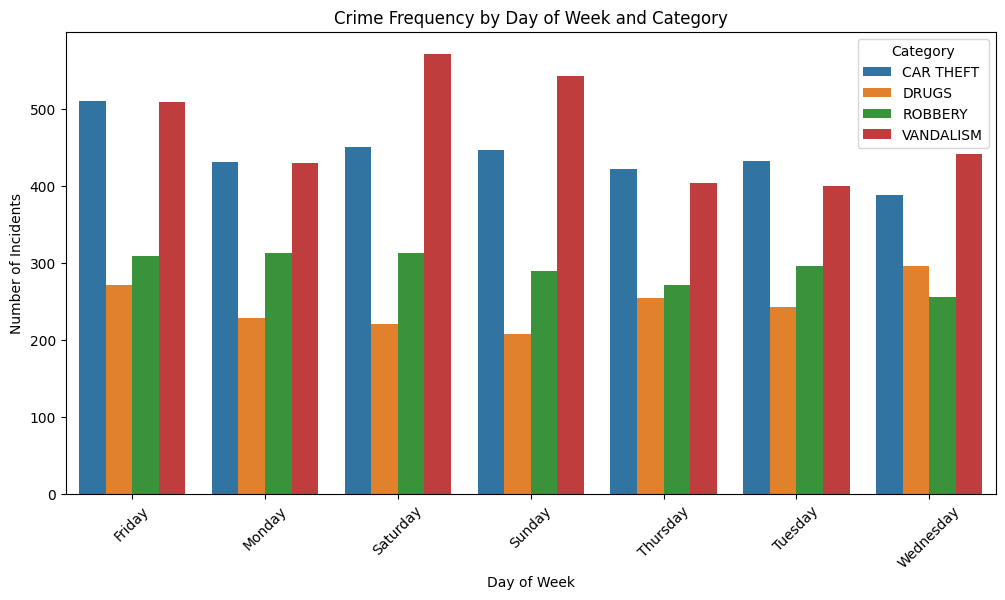

In [51]:
# 1. Crime Frequency by DayOfWeek and Category
# Bar chart: DayOfWeek and Category
plt.figure(figsize=(12, 6))
sns.countplot(data=crime_data, x='DayOfWeek', hue='Category')
plt.title('Crime Frequency by Day of Week and Category')
plt.xlabel('Day of Week')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.show()

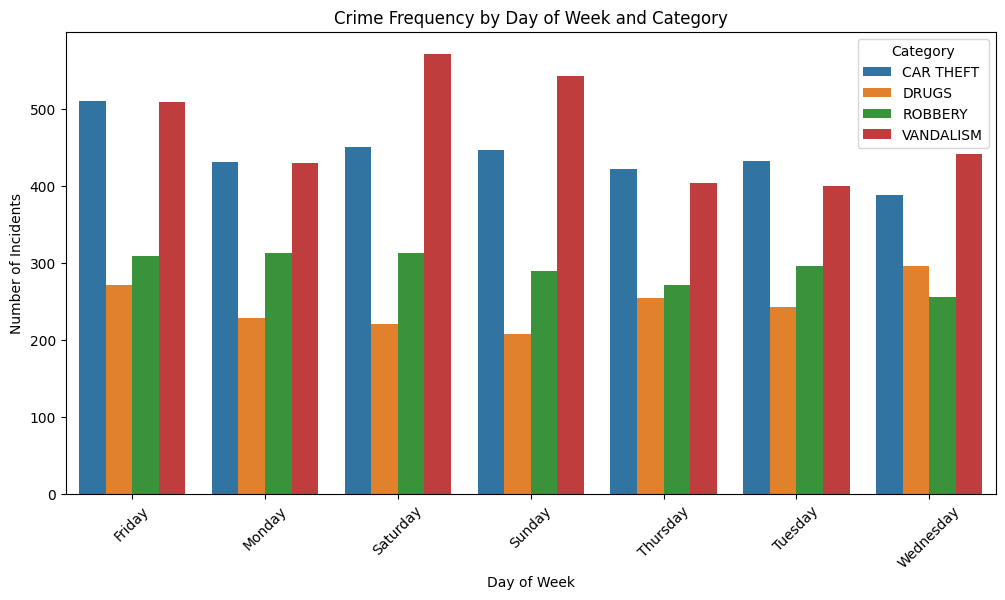

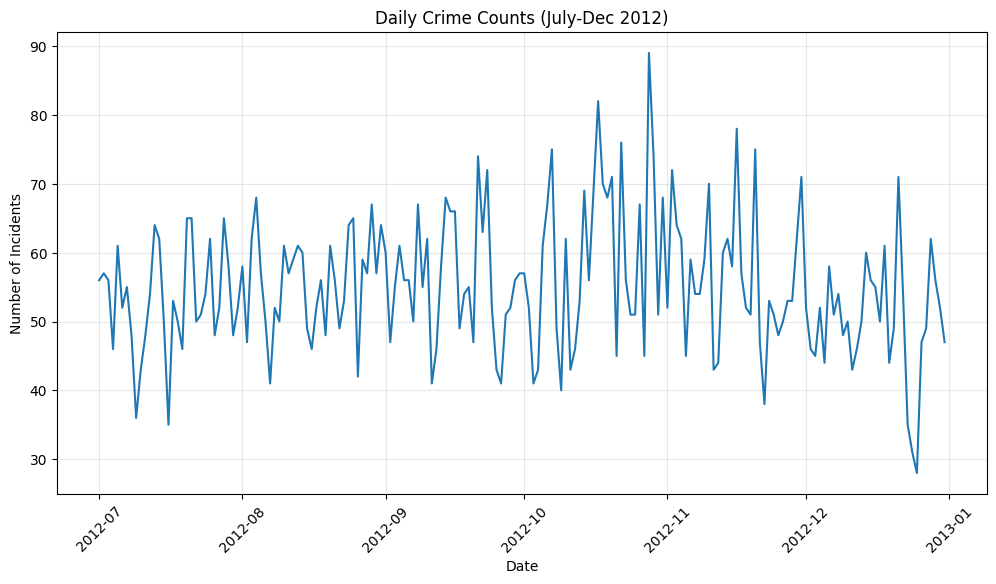

In [18]:
# Time series by Date (daily counts)
daily_crimes = crime_data.groupby(crime_data['DateTime'].dt.date).size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_crimes.index, y=daily_crimes.values)
plt.title('Daily Crime Counts (July-Dec 2012)')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

### 2. Resolution Rates by Category

<Figure size 1200x600 with 0 Axes>

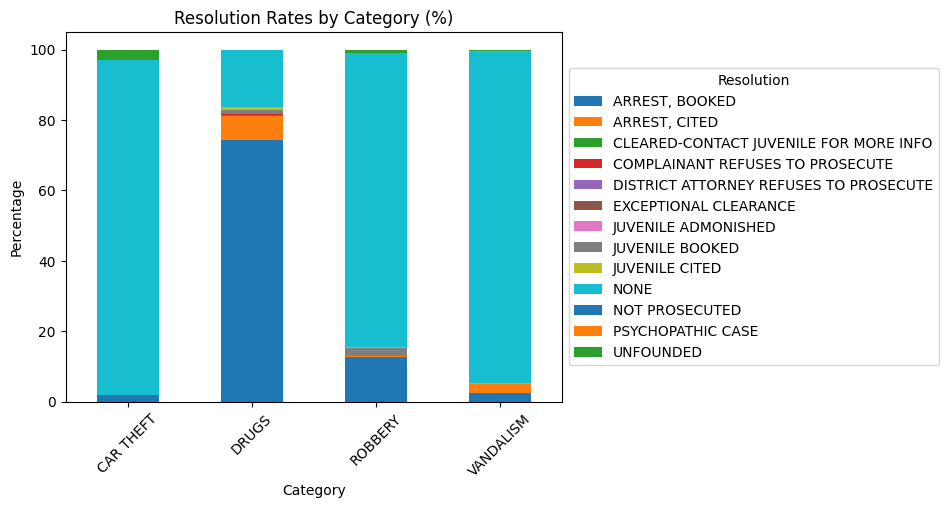


Resolution Rates by Category (%):
Resolution  ARREST, BOOKED  ARREST, CITED  \
Category                                    
CAR THEFT             1.75           0.03   
DRUGS                74.35           6.86   
ROBBERY              12.76           0.10   
VANDALISM             2.46           2.40   

Resolution  CLEARED-CONTACT JUVENILE FOR MORE INFO  \
Category                                             
CAR THEFT                                     0.00   
DRUGS                                         0.12   
ROBBERY                                       0.00   
VANDALISM                                     0.00   

Resolution  COMPLAINANT REFUSES TO PROSECUTE  \
Category                                       
CAR THEFT                               0.00   
DRUGS                                   0.47   
ROBBERY                                 0.00   
VANDALISM                               0.09   

Resolution  DISTRICT ATTORNEY REFUSES TO PROSECUTE  EXCEPTIONAL CLEARANCE  \
Cat

In [19]:
plt.figure(figsize=(12, 6))
resolution_rates = pd.crosstab(crime_data['Category'], crime_data['Resolution'], normalize='index') * 100
resolution_rates.plot(kind='bar', stacked=True)
plt.title('Resolution Rates by Category (%)')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Resolution', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
print("\nResolution Rates by Category (%):")
print(resolution_rates.round(2))

### 3. Heatmap of Crime Density

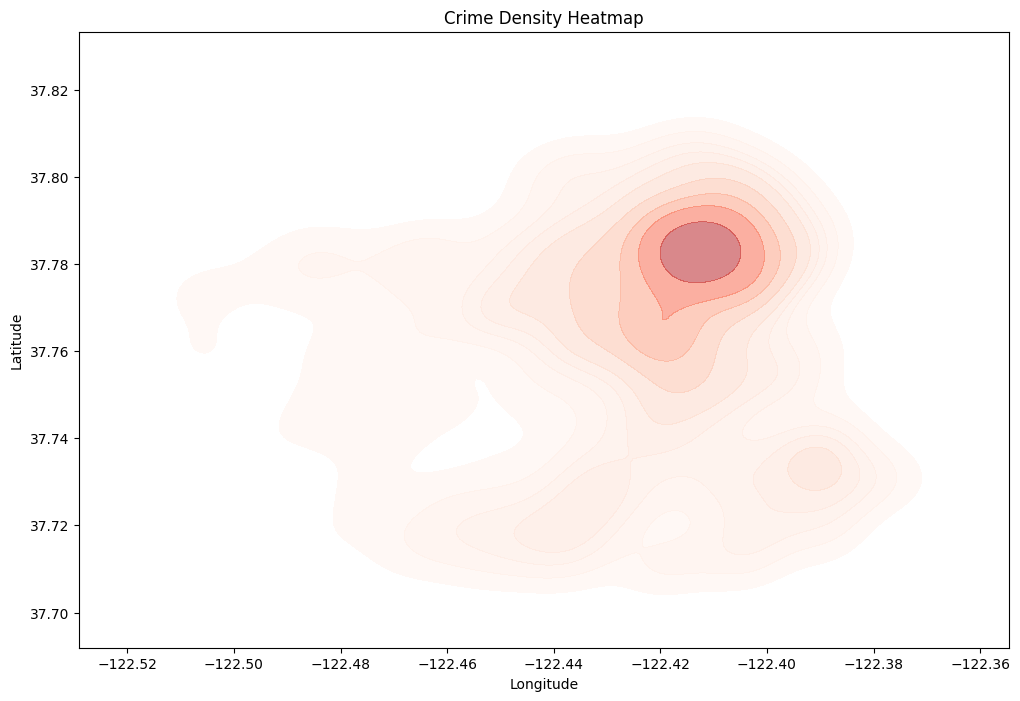

In [20]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=crime_data, x='X', y='Y', cmap='Reds', fill=True, alpha=0.5)
plt.title('Crime Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/tmp/ipykernel_40/3611185773.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_40/3611185773.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


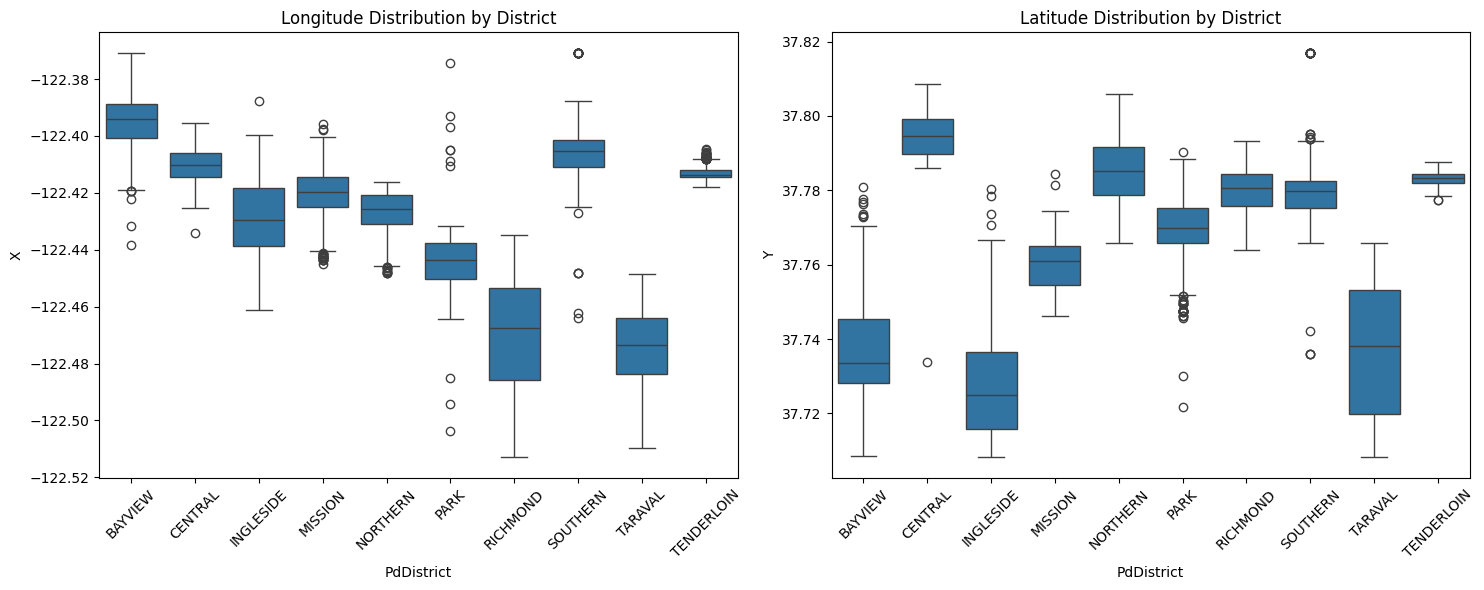


Spatial Statistics by Police District:
                  X                                Y                         \
               mean    std      min      max    mean    std     min     max   
PdDistrict                                                                    
BAYVIEW    -122.395  0.009 -122.438 -122.371  37.737  0.014  37.708  37.781   
CENTRAL    -122.410  0.006 -122.434 -122.395  37.795  0.006  37.734  37.809   
INGLESIDE  -122.428  0.014 -122.461 -122.388  37.726  0.012  37.708  37.780   
MISSION    -122.420  0.009 -122.445 -122.396  37.760  0.006  37.746  37.784   
NORTHERN   -122.427  0.007 -122.448 -122.416  37.786  0.009  37.766  37.806   
PARK       -122.444  0.010 -122.504 -122.374  37.770  0.009  37.722  37.790   
RICHMOND   -122.470  0.020 -122.513 -122.435  37.780  0.005  37.764  37.793   
SOUTHERN   -122.406  0.009 -122.464 -122.371  37.780  0.007  37.736  37.817   
TARAVAL    -122.475  0.015 -122.510 -122.448  37.737  0.018  37.708  37.766   
TENDERLOIN -

In [21]:
# 4. Box Plots by District
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=crime_data, x='PdDistrict', y='X', ax=ax1)
ax1.set_title('Longitude Distribution by District')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
sns.boxplot(data=crime_data, x='PdDistrict', y='Y', ax=ax2)
ax2.set_title('Latitude Distribution by District')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# 5. District-wise Spatial Stats
print("\nSpatial Statistics by Police District:")
district_stats = crime_data.groupby('PdDistrict')[['X', 'Y']].agg(['mean', 'std', 'min', 'max'])
district_stats['X_skewness'] = crime_data.groupby('PdDistrict')['X'].apply(stats.skew)
district_stats['Y_skewness'] = crime_data.groupby('PdDistrict')['Y'].apply(stats.skew)
district_stats = district_stats.round(3)
print(district_stats)

# 6. Category-wise Spatial Stats
print("\nSpatial Statistics by Category:")
category_spatial_stats = crime_data.groupby('Category')[['X', 'Y']].agg(['mean', 'std', 'min', 'max'])
category_spatial_stats['X_skewness'] = crime_data.groupby('Category')['X'].apply(stats.skew)
category_spatial_stats['Y_skewness'] = crime_data.groupby('Category')['Y'].apply(stats.skew)
category_spatial_stats = category_spatial_stats.round(3)
print(category_spatial_stats)

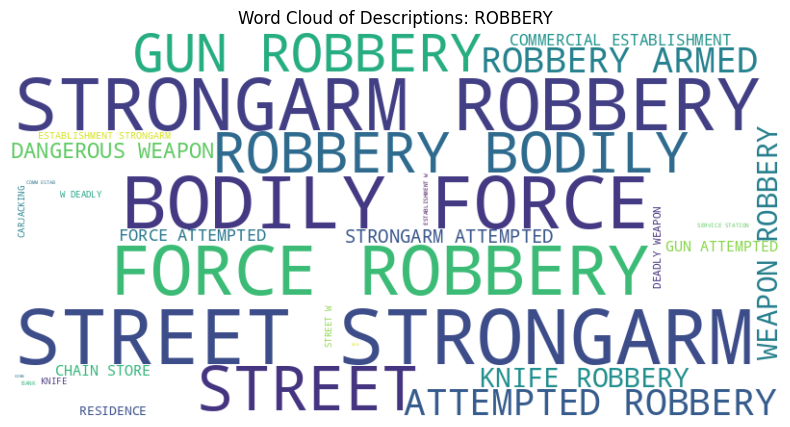

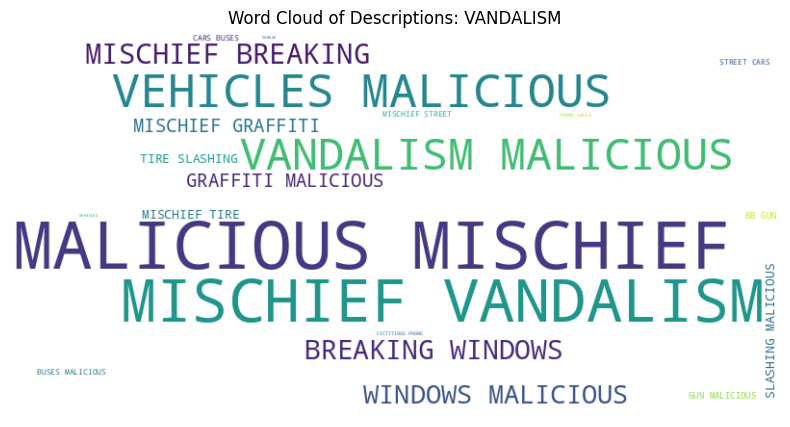

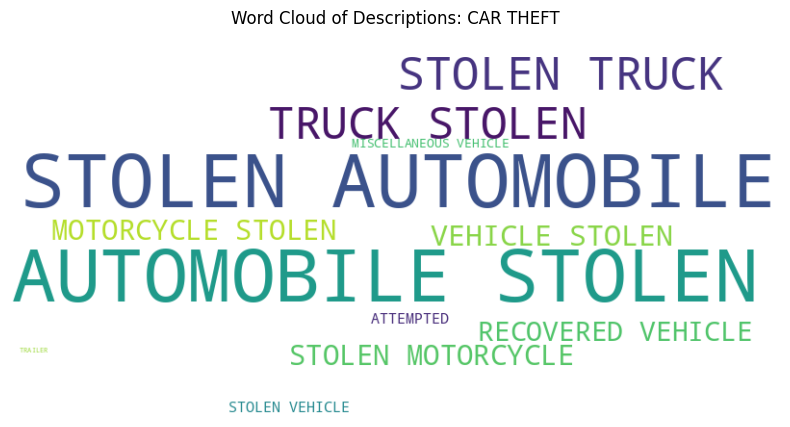

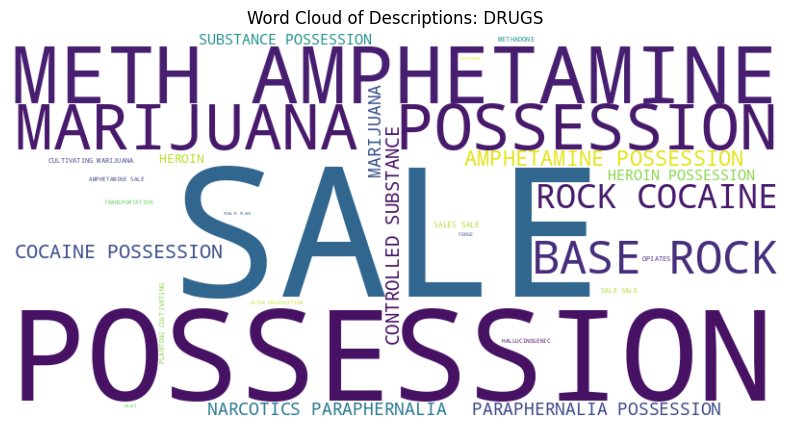

In [22]:
from wordcloud import WordCloud
# Crime Description Word Cloud
for category in crime_data['Category'].unique():
    text = ' '.join(crime_data[crime_data['Category'] == category]['Descript'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Descriptions: {category}')
    plt.show()

## Predictive modelling

### 1. ARIMA Time Series Forecasting for Jan 2013

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_40/1460723596.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nPredicted crime count for January 2013:", round(forecast[0]))

Predicted crime count for January 2013: 1546


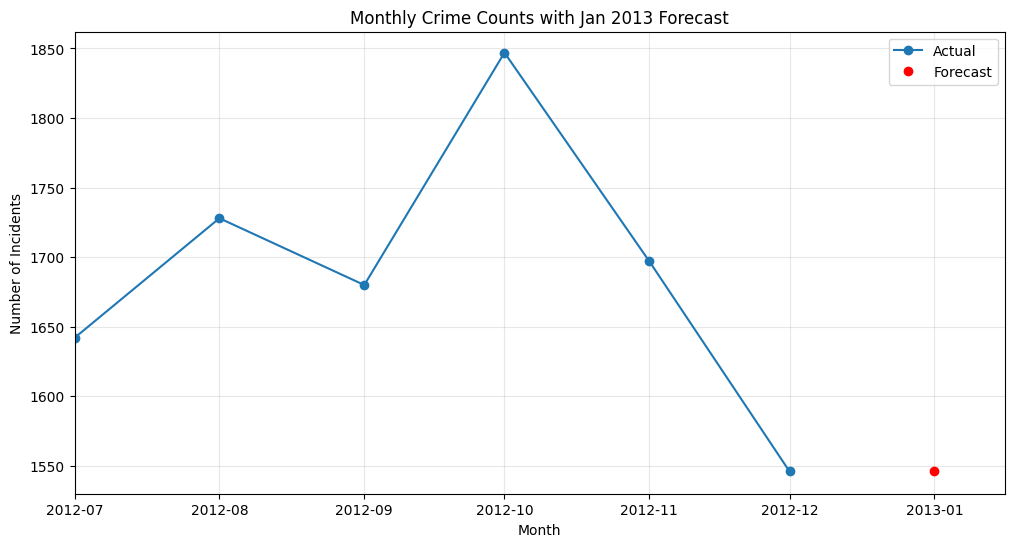

In [23]:
monthly_crimes = crime_data.groupby(crime_data['DateTime'].dt.to_period('M')).size()
monthly_crimes.index = monthly_crimes.index.to_timestamp()

model = ARIMA(monthly_crimes, order=(1, 1, 1))  # Basic order
results = model.fit()
forecast = results.forecast(steps=1)
print("\nPredicted crime count for January 2013:", round(forecast[0]))

# Create the forecast date to match the format of monthly_crimes.index
forecast_date = pd.Timestamp('2013-01-01')  # Use month-start to match to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_crimes.index, monthly_crimes.values, label='Actual', marker='o')
plt.plot([forecast_date], forecast, 'ro', label='Forecast')  # Plot forecast as a single point
plt.title('Monthly Crime Counts with Jan 2013 Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.ylim(1530)  # From your previous request
plt.legend()
plt.grid(True, alpha=0.3)

# Extend x-axis to include the forecast date
plt.xlim(monthly_crimes.index.min(), forecast_date + pd.Timedelta(days=15))  # Add some padding

plt.show()

### 2. Classification Model for Resolution (Arrest vs. None)

In [24]:
# Simplify Resolution to binary: Arrest (1) or None (0)
crime_data['Arrest'] = (crime_data['Resolution'] == 'ARREST, BOOKED').astype(int)

# Features: PdDistrict only (Hour excluded)
features = ['PdDistrict']
X = pd.get_dummies(crime_data[features], columns=['PdDistrict'])
y = crime_data['Arrest']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("\nClassification Report for Arrest Prediction:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.round(3))



Classification Report for Arrest Prediction:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1689
           1       0.57      0.27      0.36       339

    accuracy                           0.84      2028
   macro avg       0.72      0.61      0.64      2028
weighted avg       0.82      0.84      0.82      2028


Feature Importance:
                 Feature  Importance
9  PdDistrict_TENDERLOIN       0.809
2   PdDistrict_INGLESIDE       0.052
1     PdDistrict_CENTRAL       0.035
3     PdDistrict_MISSION       0.018
8     PdDistrict_TARAVAL       0.018
7    PdDistrict_SOUTHERN       0.016
6    PdDistrict_RICHMOND       0.016
0     PdDistrict_BAYVIEW       0.014
5        PdDistrict_PARK       0.011
4    PdDistrict_NORTHERN       0.010


### Spatial analysis

/tmp/ipykernel_40/2029866610.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_centroids = crime_data.groupby('Category')[['X', 'Y']].mean()


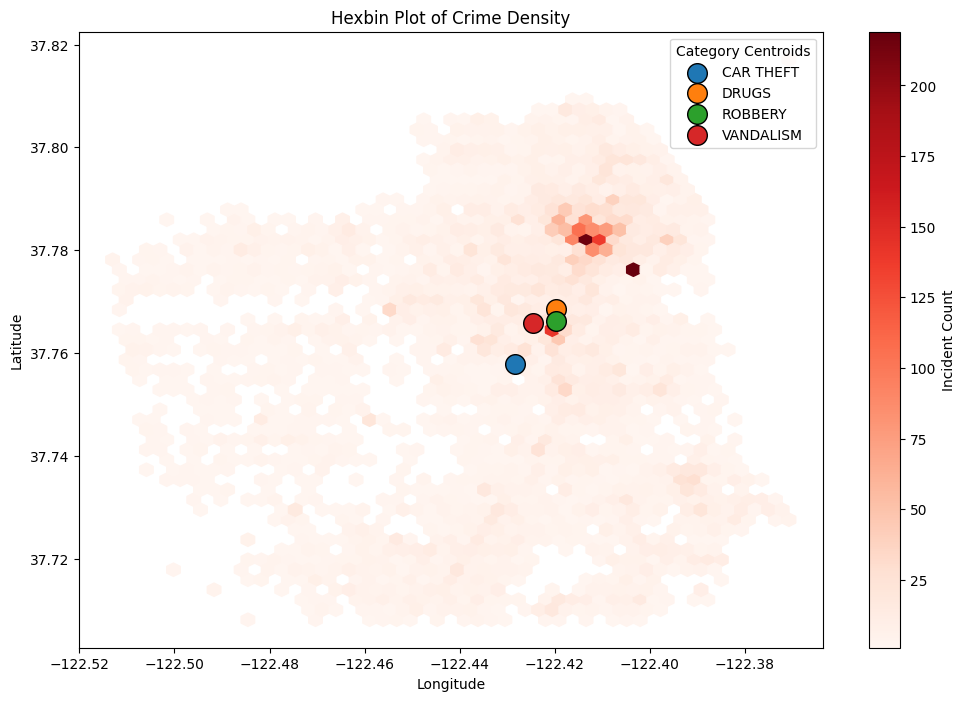

In [25]:
# Spatial Clustering with Hexbin
plt.figure(figsize=(12, 8))
hb = plt.hexbin(crime_data['X'], crime_data['Y'], gridsize=50, cmap='Reds', mincnt=1)
plt.colorbar(hb, label='Incident Count')
plt.title('Hexbin Plot of Crime Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
category_centroids = crime_data.groupby('Category')[['X', 'Y']].mean()
for category, row in category_centroids.iterrows():
    plt.scatter(row['X'], row['Y'], s=200, label=category, edgecolors='black')
plt.legend(title='Category Centroids')
plt.show()

## Temporal Analysis + Spatial Analysis + SpatialTemporal Analysis


In [26]:
# Install required packages
!pip install geopandas pandas shapely
!pip install wordcloud
!pip install statsmodels
!pip install mapclassify
!pip install contextily
!pip install folium


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 6.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import folium

In [28]:
# Load data
crime_gdf = gpd.read_file("/work/SFCrime_July_Dec2012 2/cleaned_crime_data.shp")

# Combine Date and Time into a datetime column
crime_gdf["datetime"] = pd.to_datetime(crime_gdf["Date"] + " " + crime_gdf["Time"])
crime_gdf = crime_gdf.set_geometry(gpd.points_from_xy(crime_gdf["X_pr"], crime_gdf["Y_pr"]))

In [29]:
import geopandas as gpd
import pandas as pd

# Read the CSV
file_path = '/work/SFCrime_July_Dec2012 2/SF PD Plots/SFCrime_blocks.shp'
df = pd.read_csv(file_path)

# Convert to GeoDataFrame (assuming 'geometry' column contains WKT)
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# Specify the output shapefile path
output_path = '/work/SFCrime_July_Dec2012 2/SF PD Plots/SFCrime_blocks_converted.shp'

# Write to shapefile
gdf.to_file(output_path)

print(f"Shapefile saved to {output_path}")

/root/venv/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
Shapefile saved to /work/SFCrime_July_Dec2012 2/SF PD Plots/SFCrime_blocks_converted.shp


In [30]:
sfpd_gdf = gpd.read_file('/work/SFCrime_July_Dec2012 2/SF PD Plots/SFCrime_blocks_converted.shp')
sfpd_gdf

GEO_ID  STATE  COUNTY  TRACT  BLKGRP  NAME LSAD  \
0    1500000US060750314005      6      75  31400       5     5   BG   
1    1500000US060750326011      6      75  32601       1     1   BG   
2    1500000US060750326012      6      75  32601       2     2   BG   
3    1500000US060750326013      6      75  32601       3     3   BG   
4    1500000US060750326021      6      75  32602       1     1   BG   
..                     ...    ...     ...    ...     ...   ...  ...   
574  1500000US060750207001      6      75  20700       1     1   BG   
575  1500000US060750228021      6      75  22802       1     1   BG   
576  1500000US060750232002      6      75  23200       2     2   BG   
577  1500000US060750262004      6      75  26200       4     4   BG   
578  1500000US060750308005      6      75  30800       5     5   BG   

     CENSUSAREA  Population      GEO_id2  \
0         0.052        1381  60750314005   
1         0.055        1499  60750326011   
2         0.053        1423  60750326012   
3         0.054        1494  60750326013   
4         0.076        1806  60750326021   
..          ...         ...          ...   
574       0.054        2295  60750207001   
575       0.038         576  60750228021   
576       0.199        1688  60750232002   
577       0.057        1566  60750262004   
578       0.098        1691  60750308005   

                                            GEO_displa  Vandalism  Robbery  \
0    Block Group 5, Census Tract 314, San Francisco...          3        1   
1    Block Group 1, Census Tract 326.01, San Franci...          2        1   
2    Block Group 2, Census Tract 326.01, San Franci...          2        2   
3    Block Group 3, Census Tract 326.01, San Franci...          2        0   
4    Block Group 1, Census Tract 326.02, San Franci...          2        0   
..                                                 ...        ...      ...   
574  Block Group 1, Census Tract 207, San Francisco...         25        5   
575  Block Group 1, Census Tract 228.02, San Franci...          5        1   
576  Block Group 2, Census Tract 232, San Francisco...         10        3   
577  Block Group 4, Census Tract 262, San Francisco...          3        1   
578  Block Group 5, Census Tract 308, San Francisco...          7        3   

     Drugs  CarTheft                                           geometry  
0        6         4  POLYGON ((-122.46262 37.71562, -122.46264 37.7...  
1        5         4  POLYGON ((-122.48476 37.76512, -122.48352 37.7...  
2        1         2  POLYGON ((-122.4845 37.76137, -122.48463 37.76...  
3        0         1  POLYGON ((-122.48436 37.7595, -122.4845 37.761...  
4        0         0  POLYGON ((-122.48625 37.75568, -122.48638 37.7...  
..     ...       ...                                                ...  
574      2        10  POLYGON ((-122.42623 37.76303, -122.42396 37.7...  
575      2         6  POLYGON ((-122.40742 37.76449, -122.40509 37.7...  
576     23        25  POLYGON ((-122.38452 37.72286, -122.38521 37.7...  
577      0         2  POLYGON ((-122.46086 37.71059, -122.45731 37.7...  
578      5         9  POLYGON ((-122.47541 37.73932, -122.47548 37.7...  

[579 rows x 16 columns]

In [31]:
crime_gdf

IncidntNum          X_pr          Y_pr Category  \
0       120516979  5.996647e+06  2.088056e+06  ROBBERY   
1       120517096  6.018850e+06  2.094117e+06  ROBBERY   
2       120519058  6.009324e+06  2.114646e+06  ROBBERY   
3       120519064  6.010023e+06  2.115050e+06  ROBBERY   
4       120519268  6.011070e+06  2.115794e+06  ROBBERY   
...           ...           ...           ...      ...   
10135   121038497  6.008607e+06  2.112811e+06    DRUGS   
10136   121048634  6.008465e+06  2.113832e+06    DRUGS   
10137   121049745  6.004749e+06  2.108265e+06    DRUGS   
10138   121051728  6.006257e+06  2.115823e+06    DRUGS   
10139   121053514  5.994899e+06  2.112847e+06    DRUGS   

                                                Descript  DayOfWeek  \
0                       ROBBERY ON THE STREET, STRONGARM     Sunday   
1                      ROBBERY OF A RESIDENCE WITH A GUN     Sunday   
2                                  ROBBERY, BODILY FORCE     Sunday   
3                       ROBBERY ON THE STREET, STRONGARM     Sunday   
4      ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE     Sunday   
...                                                  ...        ...   
10135                  POSSESSION OF METHADONE FOR SALES  Wednesday   
10136                     POSSESSION OF HEROIN FOR SALES     Sunday   
10137                  POSSESSION OF METHADONE FOR SALES     Sunday   
10138              POSSESSION OF NARCOTICS PARAPHERNALIA     Monday   
10139                 POSSESSION OF CONTROLLED SUBSTANCE     Monday   

             Date      Time  PdDistrict      Resolution  \
0      2012-07-01  00:00:00     TARAVAL            NONE   
1      2012-07-01  00:00:00     BAYVIEW            NONE   
2      2012-07-01  00:00:00  TENDERLOIN            NONE   
3      2012-07-01  00:00:00     CENTRAL            NONE   
4      2012-07-01  00:00:00     CENTRAL            NONE   
...           ...       ...         ...             ...   
10135  2012-12-26  00:00:00  TENDERLOIN  ARREST, BOOKED   
10136  2012-12-30  00:00:00  TENDERLOIN  ARREST, BOOKED   
10137  2012-12-30  00:00:00     MISSION  ARREST, BOOKED   
10138  2012-12-31  00:00:00    NORTHERN  ARREST, BOOKED   
10139  2012-12-31  00:00:00    RICHMOND  ARREST, BOOKED   

                              Location           X          Y   DateTime  \
0               BROAD ST / SAN JOSE AV -122.453458  37.713212 2012-07-01   
1                 0 Block of HARBOR RD -122.377137  37.731101 2012-07-01   
2                 GEARY ST / TAYLOR ST -122.411519  37.786941 2012-07-01   
3                 400 Block of POST ST -122.409131  37.788090 2012-07-01   
4                300 Block of GRANT AV -122.405560  37.790191 2012-07-01   
...                                ...         ...        ...        ...   
10135  LEAVENWORTH ST / GOLDEN GATE AV -122.413870  37.781862 2012-12-26   
10136        ELLIS ST / LEAVENWORTH ST -122.414433  37.784658 2012-12-30   
10137          2000 Block of MARKET ST -122.426893  37.769162 2012-12-30   
10138         1500 Block of VANNESS AV -122.422214  37.789999 2012-12-31   
10139           3900 Block of GEARY BL -122.461295  37.781181 2012-12-31   

                              geometry   datetime  
0              POINT (5996647 2088056) 2012-07-01  
1      POINT (6018849.717 2094116.539) 2012-07-01  
2              POINT (6009324 2114646) 2012-07-01  
3       POINT (6010022.55 2115050.097) 2012-07-01  
4      POINT (6011069.566 2115794.082) 2012-07-01  
...                                ...        ...  
10135          POINT (6008607 2112811) 2012-12-26  
10136          POINT (6008465 2113832) 2012-12-30  
10137   POINT (6004748.865 2108264.74) 2012-12-30  
10138  POINT (6006256.865 2115822.681) 2012-12-31  
10139  POINT (5994899.151 2112846.842) 2012-12-31  

[10140 rows x 16 columns]

In [32]:
# sfpd_gdf.crs
crime_gdf.crs


<Projected CRS: EPSG:2227>
Name: NAD83 / California zone 3 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Alameda; Calaveras; Contra Costa; Madera; Marin; Mariposa; Merced; Mono; San Francisco; San Joaquin; San Mateo; Santa Clara; Santa Cruz; Stanislaus; Tuolumne.
- bounds: (-123.02, 36.73, -117.83, 38.71)
Coordinate Operation:
- name: SPCS83 California zone 3 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
import geopandas as gpd

# Set the CRS to a known EPSG code (for example, EPSG:4326, which is WGS 84)
target_crs = "EPSG:4326"  # Replace with the CRS you want

# Set the CRS for both GeoDataFrames
sfpd_gdf = sfpd_gdf.set_crs(target_crs, allow_override=True)



In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For Jupyter notebooks, ensure plots display inline
%matplotlib inline

# Step 2: Inspect the data before the join
print("sfpd_gdf sample:\n", sfpd_gdf[['GEO_ID', 'geometry']].head())
print("crime_gdf sample:\n", crime_gdf[['geometry']].head())
print("sfpd_gdf bounds (before setting CRS):\n", sfpd_gdf.geometry.bounds)
print("crime_gdf bounds (before setting CRS):\n", crime_gdf.geometry.bounds)

# Step 3: Ensure both GeoDataFrames are in the same CRS (EPSG:4326)
print("sfpd_gdf CRS:", sfpd_gdf.crs)
print("crime_gdf CRS:", crime_gdf.crs)

# If sfpd_gdf is not in EPSG:4326, reproject it
if sfpd_gdf.crs != "EPSG:4326":
    print("Reprojecting sfpd_gdf to WGS84 (EPSG:4326)...")
    sfpd_gdf = sfpd_gdf.to_crs(epsg=4326)

# If crime_gdf is not in EPSG:4326, reproject it
if crime_gdf.crs != "EPSG:4326":
    print("Reprojecting crime_gdf to WGS84 (EPSG:4326)...")
    crime_gdf = crime_gdf.to_crs(epsg=4326)

# Verify CRS after reprojection
print("sfpd_gdf CRS (after reprojection):", sfpd_gdf.crs)
print("crime_gdf CRS (after reprojection):", crime_gdf.crs)

# Verify coordinate ranges for San Francisco
sfpd_bounds = sfpd_gdf.geometry.bounds
crime_bounds = crime_gdf.geometry.bounds

print("sfpd_gdf bounds (after reprojection):\n", sfpd_bounds)
print("crime_gdf bounds (after reprojection):\n", crime_bounds)

# Check if crime_gdf coordinates are in the expected range for San Francisco
if (crime_bounds['minx'].min() < -123 or crime_bounds['maxx'].max() > -122 or
    crime_bounds['miny'].min() < 37 or crime_bounds['maxy'].max() > 38):
    print("WARNING: crime_gdf coordinates are not in the expected range for San Francisco!")
    print("Expected range: longitude (-123 to -122), latitude (37 to 38)")

# Step 4: Perform the spatial join in EPSG:4326
print("Performing spatial join with 'within' predicate in EPSG:4326...")
crime_with_sfpd = gpd.sjoin(crime_gdf, sfpd_gdf, how='left', predicate='within')
print("Number of rows in crime_with_sfpd:", len(crime_with_sfpd))
print("Sample of crime_with_sfpd:\n", crime_with_sfpd[['geometry', 'GEO_ID']].head())
print("Number of rows with non-null GEO_ID:", crime_with_sfpd['GEO_ID'].notna().sum())

# Try with 'intersects' predicate if no matches
if crime_with_sfpd['GEO_ID'].notna().sum() == 0:
    print("No matches with 'within'. Trying 'intersects' predicate...")
    crime_with_sfpd = gpd.sjoin(crime_gdf, sfpd_gdf, how='left', predicate='intersects')
    print("Number of rows with non-null GEO_ID (intersects):", crime_with_sfpd['GEO_ID'].notna().sum())

# Buffer the crime points if still no matches
if crime_with_sfpd['GEO_ID'].notna().sum() == 0:
    print("No matches with 'intersects'. Buffering crime points...")
    crime_gdf_buffered = crime_gdf.copy()
    # Buffer by ~50 meters (0.0005 degrees ~ 50 meters in WGS84 at this latitude)
    crime_gdf_buffered['geometry'] = crime_gdf_buffered.geometry.buffer(0.0005)
    crime_with_sfpd = gpd.sjoin(crime_gdf_buffered, sfpd_gdf, how='left', predicate='intersects')
    print("Number of rows with non-null GEO_ID (buffered):", crime_with_sfpd['GEO_ID'].notna().sum())

# Step 5: Aggregate crime counts per SFPD plot
if crime_with_sfpd['GEO_ID'].notna().sum() > 0:
    crime_counts = crime_with_sfpd.groupby('GEO_ID').size().reset_index(name='crime_count')
    print("Crime counts per GEO_ID:\n", crime_counts.head())
    print("Summary of crime counts:\n", crime_counts['crime_count'].describe())

    # Ensure GEO_ID columns are of the same type
    print("sfpd_gdf GEO_ID type:", sfpd_gdf['GEO_ID'].dtype)
    print("crime_counts GEO_ID type:", crime_counts['GEO_ID'].dtype)
    sfpd_gdf['GEO_ID'] = sfpd_gdf['GEO_ID'].astype(str)
    crime_counts['GEO_ID'] = crime_counts['GEO_ID'].astype(str)

    # Check for duplicates in sfpd_gdf
    if sfpd_gdf['GEO_ID'].duplicated().any():
        print("WARNING: Duplicates found in sfpd_gdf GEO_ID. Dropping duplicates...")
        sfpd_gdf = sfpd_gdf.drop_duplicates(subset='GEO_ID')

    # Check for existing crime_count-related columns and drop them
    crime_count_cols = [col for col in sfpd_gdf.columns if 'crime_count' in col]
    if crime_count_cols:
        print(f"Found existing crime_count-related columns: {crime_count_cols}. Dropping them...")
        sfpd_gdf = sfpd_gdf.drop(columns=crime_count_cols)

    # Verify columns before merge
    print("sfpd_gdf columns before merge:", sfpd_gdf.columns.tolist())

    # Merge the crime counts back into sfpd_gdf
    try:
        sfpd_gdf = sfpd_gdf.merge(crime_counts, on='GEO_ID', how='left').fillna({'crime_count': 0})
        print("sfpd_gdf with crime counts:\n", sfpd_gdf[['GEO_ID', 'crime_count']].head())
        print("Summary of crime counts in sfpd_gdf:\n", sfpd_gdf['crime_count'].describe())
    except Exception as e:
        print(f"Error during merge: {e}")
        # Fallback: Add crime_count column with zeros
        sfpd_gdf['crime_count'] = 0
        print("Added 'crime_count' column with zeros to sfpd_gdf as a fallback.")
else:
    print("No crime points matched to any SFPD polygons.")
    # Fallback: Add a crime_count column with zeros
    sfpd_gdf['crime_count'] = 0
    print("Added 'crime_count' column with zeros to sfpd_gdf.")
    print("sfpd_gdf with crime counts:\n", sfpd_gdf[['GEO_ID', 'crime_count']].head())

sfpd_gdf sample:
                   GEO_ID                                           geometry
0  1500000US060750314005  POLYGON ((-122.46262 37.71562, -122.46264 37.7...
1  1500000US060750326011  POLYGON ((-122.48476 37.76512, -122.48352 37.7...
2  1500000US060750326012  POLYGON ((-122.4845 37.76137, -122.48463 37.76...
3  1500000US060750326013  POLYGON ((-122.48436 37.7595, -122.4845 37.761...
4  1500000US060750326021  POLYGON ((-122.48625 37.75568, -122.48638 37.7...
crime_gdf sample:
                           geometry
0          POINT (5996647 2088056)
1  POINT (6018849.717 2094116.539)
2          POINT (6009324 2114646)
3   POINT (6010022.55 2115050.097)
4  POINT (6011069.566 2115794.082)
sfpd_gdf bounds (before setting CRS):
            minx       miny        maxx       maxy
0   -122.462640  37.715619 -122.456087  37.718235
1   -122.484759  37.763231 -122.477121  37.765448
2   -122.484627  37.761370 -122.476964  37.763559
3   -122.484496  37.759501 -122.476748  37.761699
4   -122

1. Spatial Analysis: Plot Crime Points by Category

crime_gdf CRS: EPSG:4326
sfpd_gdf CRS: EPSG:4326
Number of rows in crime_gdf: 10140


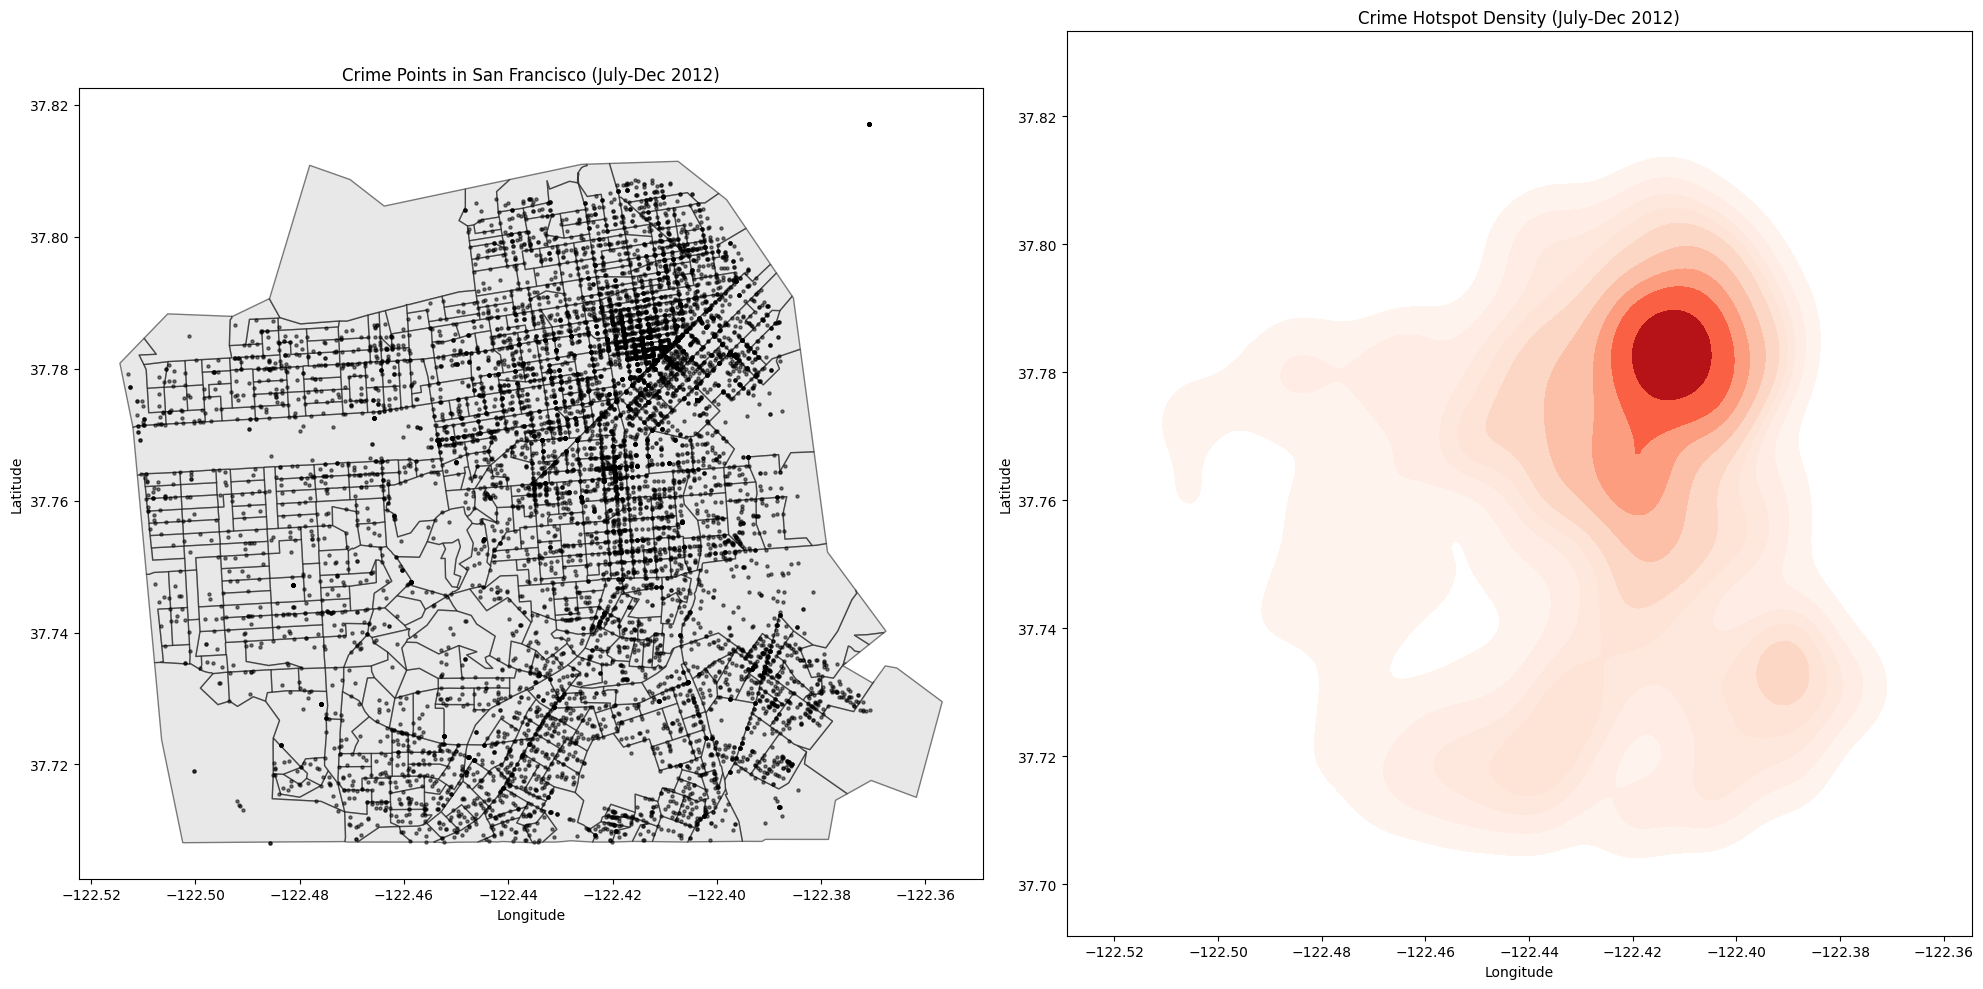

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Check CRS and data
print("crime_gdf CRS:", crime_gdf.crs)
print("sfpd_gdf CRS:", sfpd_gdf.crs)
print("Number of rows in crime_gdf:", len(crime_gdf))

# Ensure crime_gdf has the same CRS as sfpd_gdf
if crime_gdf.crs != sfpd_gdf.crs:
    crime_gdf = crime_gdf.to_crs(sfpd_gdf.crs)
    print("crime_gdf reprojected to:", crime_gdf.crs)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Subplot 1: Crime points
# Plot the SFPD polygons as a base layer
sfpd_gdf.plot(ax=ax1, color='lightgray', edgecolor='black', alpha=0.5)
# Plot the crime points on top
crime_gdf.plot(ax=ax1, color='black', markersize=5, alpha=0.5)
ax1.set_title('Crime Points in San Francisco (July-Dec 2012)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Subplot 2: Crime density (KDE)
# Plot the SFPD polygons as a base layer
# sfpd_gdf.plot(ax=ax2, color='lightgray', edgecolor='black', alpha=0.5)
# Plot the KDE on top
sns.kdeplot(
    data=crime_gdf,
    x=crime_gdf.geometry.x,  # Longitude
    y=crime_gdf.geometry.y,  # Latitude
    cmap="Reds",
    fill=True,
    levels=10,
    ax=ax2
)
ax2.set_title('Crime Hotspot Density (July-Dec 2012)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Adjust layout and display
plt.tight_layout()
plt.show()

1. Spatial Analysis : Spatial Distribution of Different Crime Type

Unique crime categories in crime_gdf: ['ROBBERY' 'VANDALISM' 'CAR THEFT' 'DRUGS']
crime_gdf CRS: EPSG:4326
sfpd_gdf CRS: EPSG:4326


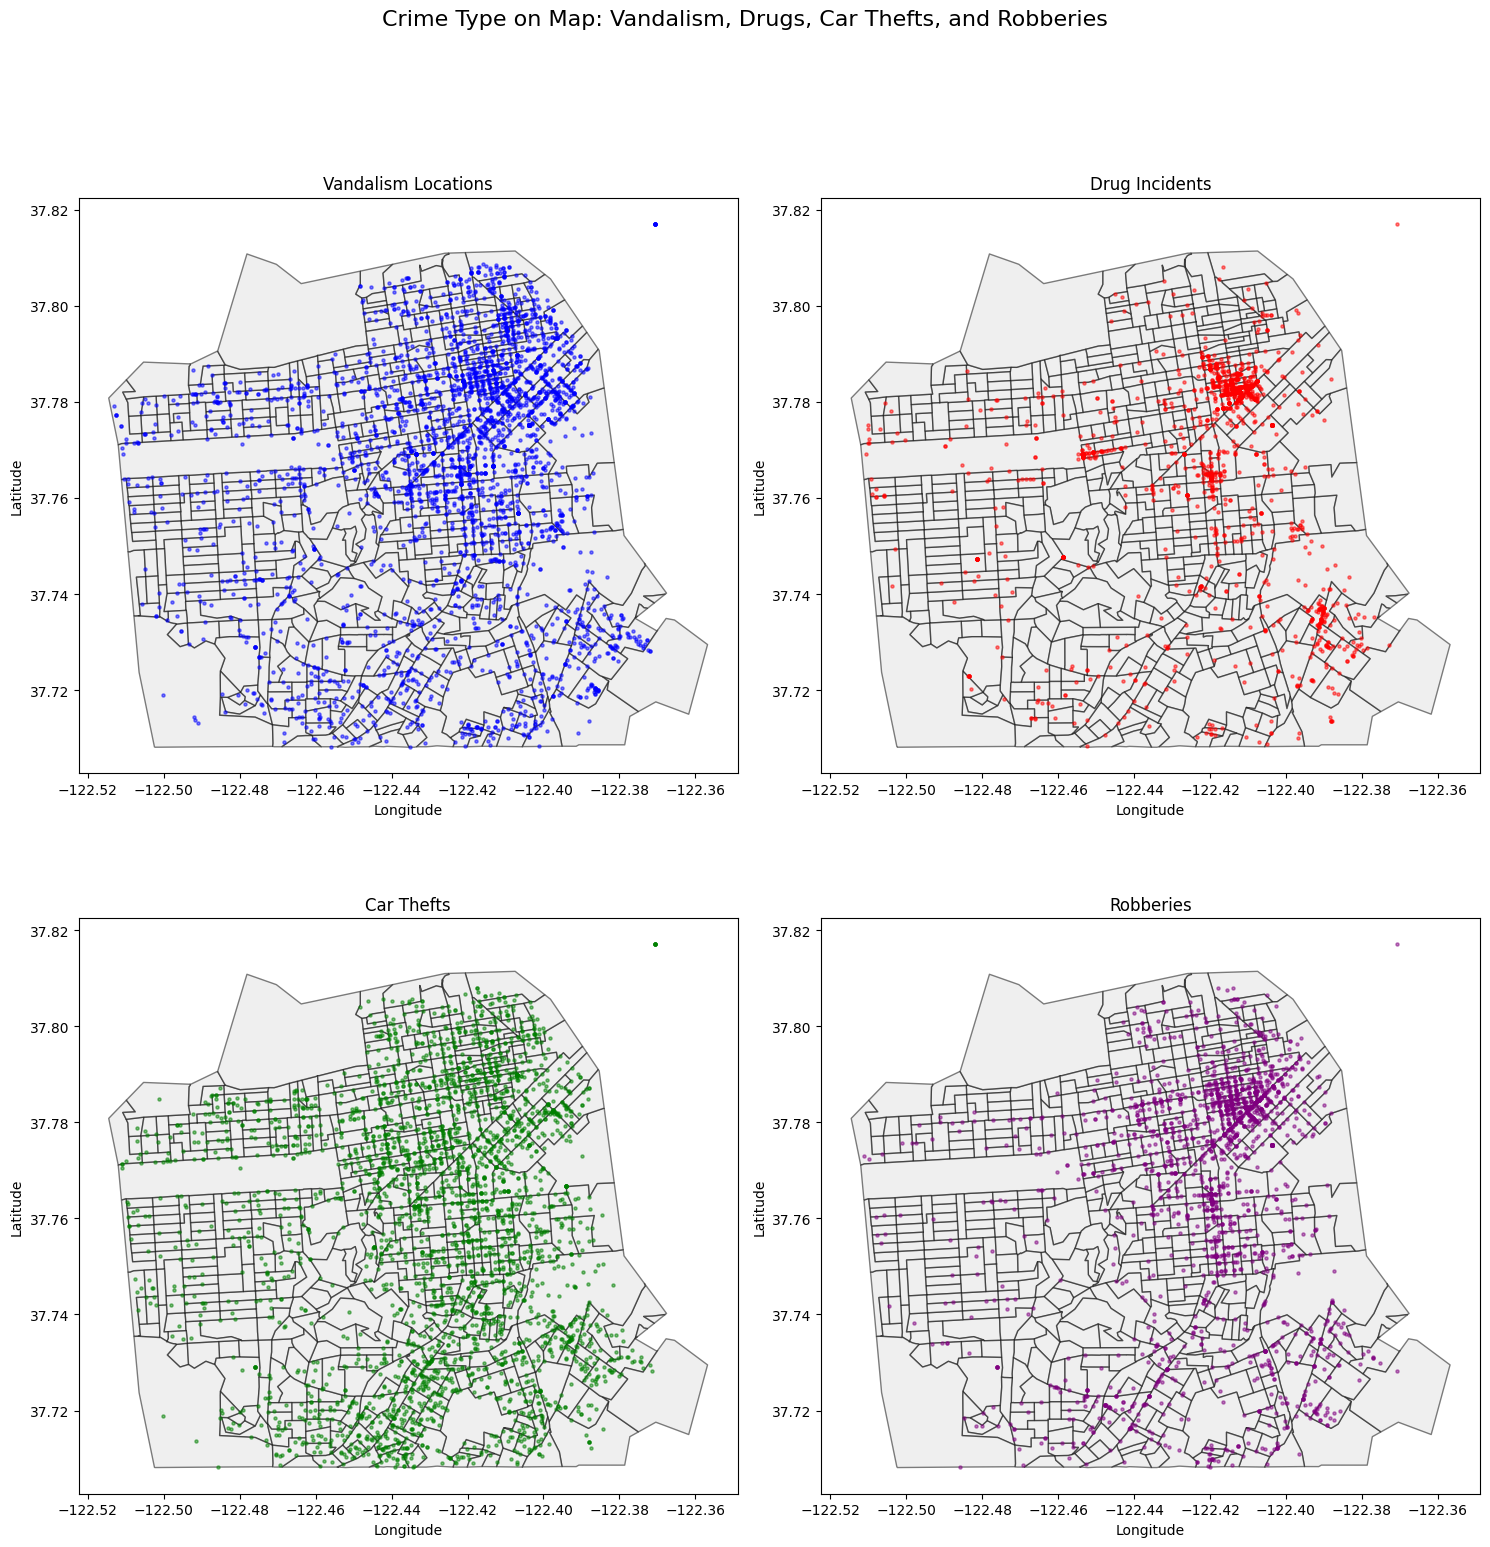

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Check unique categories and CRS to confirm
print("Unique crime categories in crime_gdf:", crime_gdf['Category'].unique())
print("crime_gdf CRS:", crime_gdf.crs)
print("sfpd_gdf CRS:", sfpd_gdf.crs)

# Filter by Category (adjust category names based on your data)
vandalism = crime_gdf[crime_gdf["Category"] == "VANDALISM"]
drugs = crime_gdf[crime_gdf["Category"] == "DRUGS"]  # Adjusted from "DRUGS"
car_theft = crime_gdf[crime_gdf["Category"] == "CAR THEFT"]  # Adjusted from "CAR THEFT"
robberies = crime_gdf[crime_gdf["Category"] == "ROBBERY"]  # Adjusted from "ROBBERIES"

# Reproject crime_gdf to match sfpd_gdf's CRS
if crime_gdf.crs != sfpd_gdf.crs:
    crime_gdf = crime_gdf.to_crs(sfpd_gdf.crs)
    print("crime_gdf reprojected to:", crime_gdf.crs)

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Plot each crime category with sfpd_gdf as the base layer
# Subplot 1: Vandalism
sfpd_gdf.plot(ax=axes[0], color="#E0E0E0", edgecolor="black", alpha=0.5)  # Base layer
vandalism.plot(ax=axes[0], color="blue", markersize=5, alpha=0.5)
axes[0].set_title("Vandalism Locations")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Subplot 2: Drugs
sfpd_gdf.plot(ax=axes[1], color="#E0E0E0", edgecolor="black", alpha=0.5)  # Base layer
drugs.plot(ax=axes[1], color="red", markersize=5, alpha=0.5)
axes[1].set_title("Drug Incidents")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

# Subplot 3: Vehicle Thefts
sfpd_gdf.plot(ax=axes[2], color="#E0E0E0", edgecolor="black", alpha=0.5)  # Base layer
car_theft.plot(ax=axes[2], color="green", markersize=5, alpha=0.5)
axes[2].set_title("Car Thefts")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")

# Subplot 4: Robberies
sfpd_gdf.plot(ax=axes[3], color="#E0E0E0", edgecolor="black", alpha=0.5)  # Base layer
robberies.plot(ax=axes[3], color="purple", markersize=5, alpha=0.5)
axes[3].set_title("Robberies")
axes[3].set_xlabel("Longitude")
axes[3].set_ylabel("Latitude")

# Add a main title for the entire figure
fig.suptitle("Crime Type on Map: Vandalism, Drugs, Car Thefts, and Robberies", fontsize=16, y=1.05)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

crime_count values in sfpd_gdf:
 count    579.000000
mean      17.481865
std       23.861283
min        0.000000
25%        6.000000
50%       11.000000
75%       20.000000
max      258.000000
Name: crime_count, dtype: float64
Number of non-zero crime_count values: 574


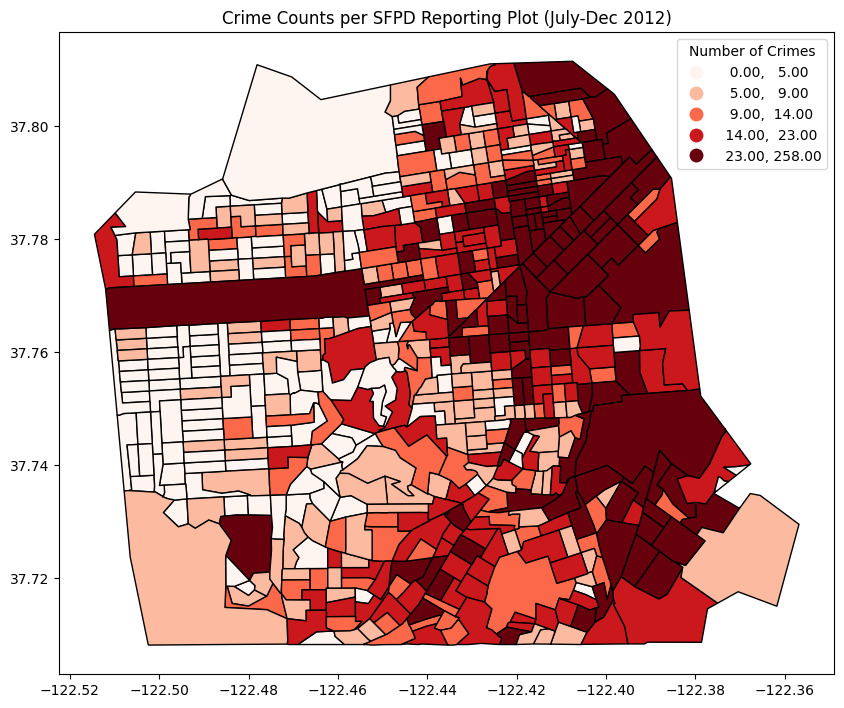

In [37]:
import matplotlib.pyplot as plt

if 'crime_count' in sfpd_gdf.columns:
    print("crime_count values in sfpd_gdf:\n", sfpd_gdf['crime_count'].describe())
    print("Number of non-zero crime_count values:", (sfpd_gdf['crime_count'] > 0).sum())

    sfpd_gdf.plot(
        column='crime_count',
        legend=True,
        cmap='Reds',
        scheme='quantiles',
        k=5,
        edgecolor='black',
        legend_kwds={'title': "Number of Crimes"},
        figsize=(10, 10)  # Pass figsize directly to sfpd_gdf.plot()
    )
    plt.title('Crime Counts per SFPD Reporting Plot (July-Dec 2012)')
    plt.show()
else:
    print("Cannot plot choropleth map: 'crime_count' column not found in sfpd_gdf.")

Using column 'Category' for crime categories.
Unique categories:
 ['ROBBERY' 'VANDALISM' 'CAR THEFT' 'DRUGS']


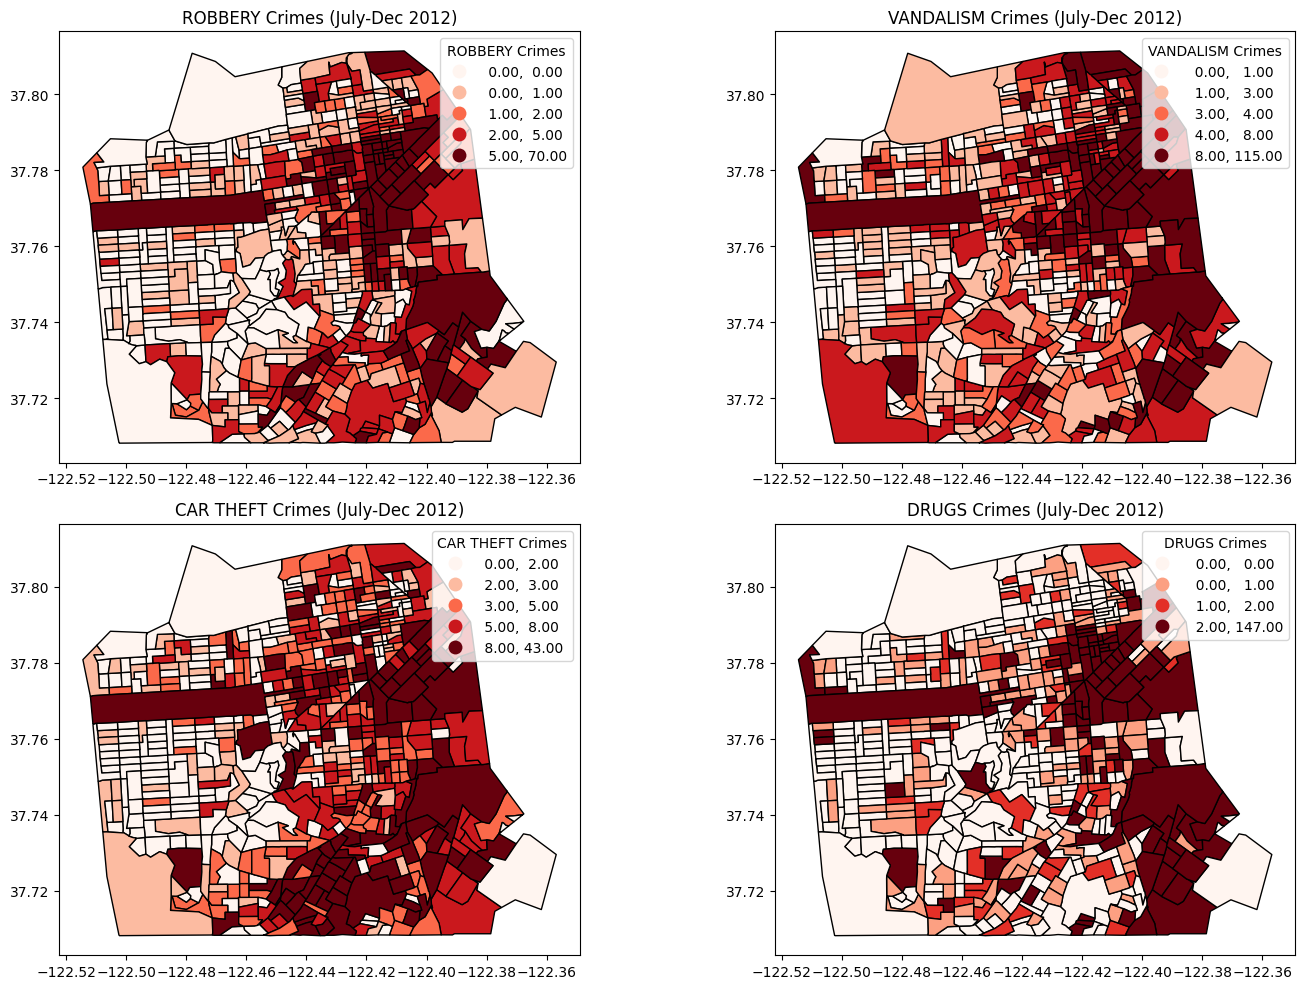

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming crime_with_sfpd and sfpd_gdf are defined and loaded

# Check for a category column
category_col = None
for col in crime_with_sfpd.columns:
    if 'category' in col.lower() or 'type' in col.lower():
        category_col = col
        break

if category_col:
    print(f"Using column '{category_col}' for crime categories.")
    print("Unique categories:\n", crime_with_sfpd[category_col].unique())

    # Focus on vandalism and drug-related crimes (adjust category names based on your data)
    categories_to_compare = ['ROBBERY', 'VANDALISM', 'CAR THEFT', 'DRUGS']  # Adjust based on actual category names

    # Aggregate by GEO_ID and category
    crime_by_category = crime_with_sfpd.groupby(['GEO_ID', category_col]).size().reset_index(name='crime_count')

    # Pivot to create a wide-format dataframe
    category_pivot = crime_by_category.pivot(index='GEO_ID', columns=category_col, values='crime_count').fillna(0)

    # Merge with sfpd_gdf
    sfpd_gdf_category = sfpd_gdf.merge(category_pivot, on='GEO_ID', how='left').fillna(0)

    # Plot choropleth maps for each category in a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 subplot grid
    axes = axes.flatten() # Flattens the 2d axes array into a 1d array for easier iteration

    for i, category in enumerate(categories_to_compare):
        if category in sfpd_gdf_category.columns:
            sfpd_gdf_category.plot(
                column=category,
                ax=axes[i],
                cmap='Reds',
                legend=True,
                scheme='quantiles',
                k=5,
                edgecolor='black',
                legend_kwds={'title': f"{category} Crimes"}
            )
            axes[i].set_title(f'{category} Crimes (July-Dec 2012)')
        else:
            print(f"Category '{category}' not found in data.")

    plt.tight_layout()
    plt.show()
else:
    print("No category column found in crime_with_sfpd. Cannot compare spatial patterns across categories.")

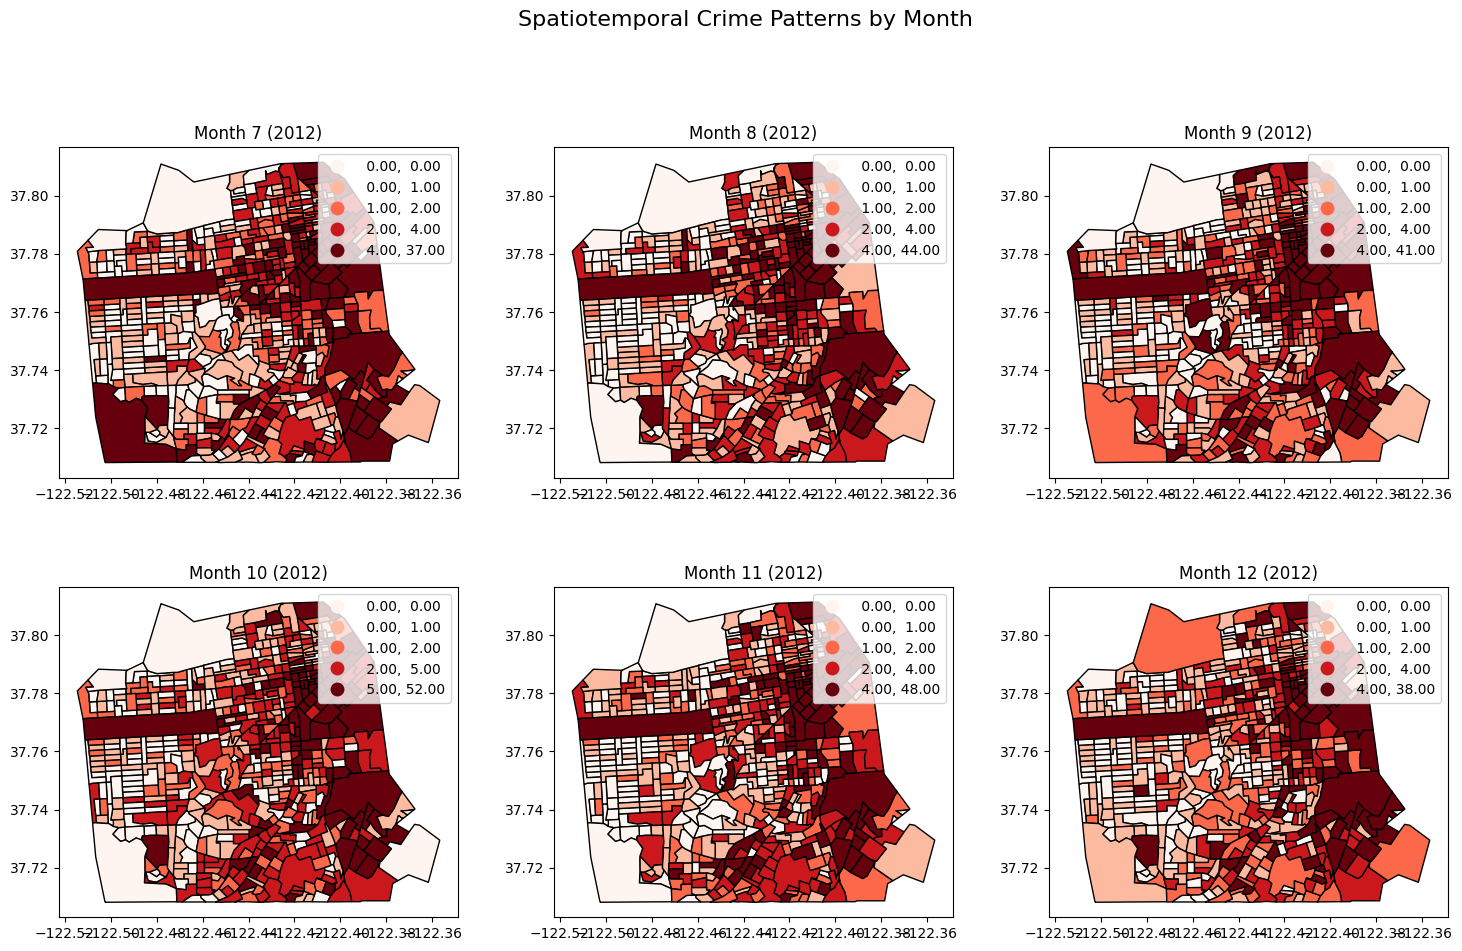

In [39]:
# Visualization 4: Spatiotemporal Analysis - Monthly Crime Maps
if 'crime_count' in sfpd_gdf.columns and 'DateTime' in crime_with_sfpd.columns:
    # Aggregate crimes by month and SFPD plot
    crime_with_sfpd['month'] = pd.to_datetime(crime_with_sfpd['DateTime']).dt.month
    monthly_crime_counts = crime_with_sfpd.groupby(['GEO_ID', 'month']).size().reset_index(name='crime_count')

    # Pivot to create a wide-format dataframe for plotting
    monthly_pivot = monthly_crime_counts.pivot(index='GEO_ID', columns='month', values='crime_count').fillna(0)

    # Merge with sfpd_gdf
    sfpd_gdf_monthly = sfpd_gdf.merge(monthly_pivot, on='GEO_ID', how='left').fillna(0)

    # Plot a series of choropleth maps for each month
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    months = range(7, 13)  # July to December
    for i, month in enumerate(months):
        if month in sfpd_gdf_monthly.columns:
            sfpd_gdf_monthly.plot(
                column=month,
                ax=axes[i],
                cmap='Reds',
                legend=True,
                scheme='quantiles',
                k=5,
                edgecolor='black',
                legend_kwds={}
            )
            axes[i].set_title(f'Month {month} (2012)')
        else:
            print(f"Cannot plot map for month {month}: column not found.")
    plt.suptitle('Spatiotemporal Crime Patterns by Month', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Cannot plot spatiotemporal maps: 'crime_count' or 'datetime' column not found.")

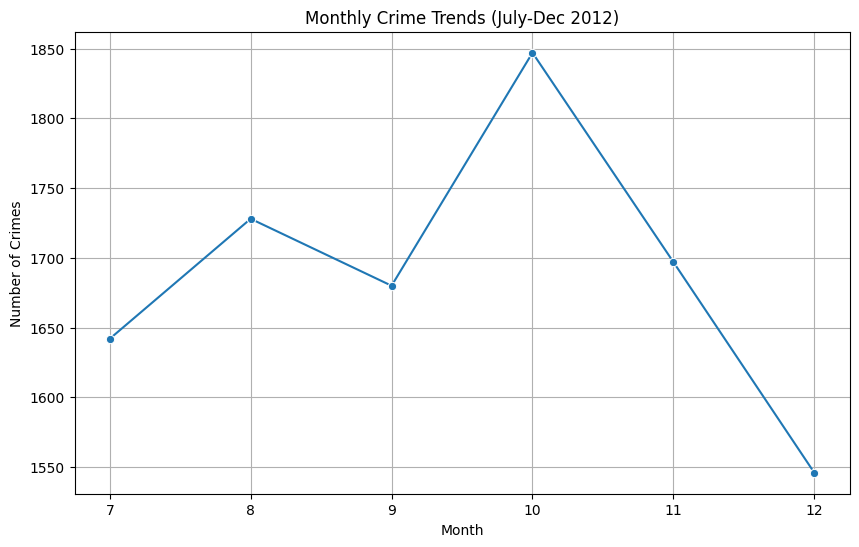

In [40]:
# Visualization 3: Monthly Crime Trends
if 'DateTime' in crime_gdf.columns:
    crime_gdf['month'] = pd.to_datetime(crime_gdf['DateTime']).dt.month
    monthly_crimes = crime_gdf.groupby('month').size().reset_index(name='crime_count')
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_crimes, x='month', y='crime_count', marker='o')
    plt.title('Monthly Crime Trends (July-Dec 2012)')
    plt.xlabel('Month')
    plt.ylabel('Number of Crimes')
    plt.xticks(range(7, 13))
    plt.grid(True)
    plt.show()
else:
    print("Cannot plot monthly trends: 'datetime' column not found in crime_gdf.")

Category pivot sample:
 Category  CAR THEFT  DRUGS  ROBBERY  VANDALISM
month                                         
7               549    267      281        545
8               513    298      366        551
9               505    287      317        571
10              516    306      361        664
11              519    292      375        511


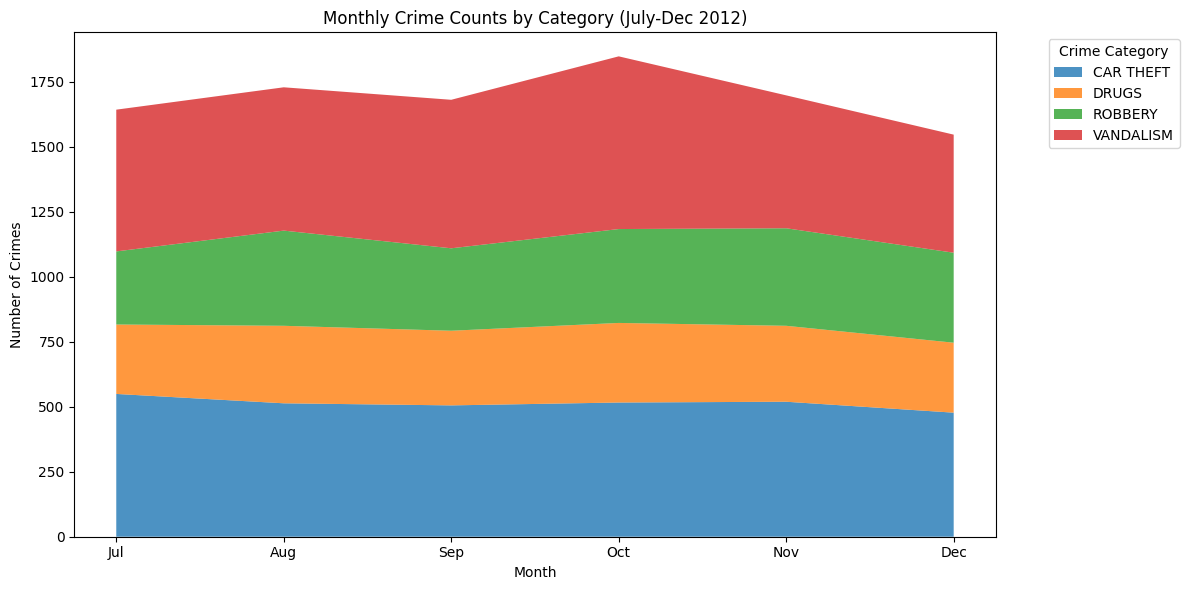

In [41]:
# Visualization 4.3: Stacked Area Chart of Crimes by Category
category_col = None
for col in crime_with_sfpd.columns:
    if 'category' in col.lower() or 'type' in col.lower():
        category_col = col
        break

if category_col and 'DateTime' in crime_with_sfpd.columns:
    # Aggregate crimes by month and category
    crime_with_sfpd['month'] = pd.to_datetime(crime_with_sfpd['DateTime']).dt.month
    category_monthly_counts = crime_with_sfpd.groupby(['month', category_col]).size().reset_index(name='crime_count')

    # Pivot to create a wide-format dataframe
    category_pivot = category_monthly_counts.pivot(index='month', columns=category_col, values='crime_count').fillna(0)
    print("Category pivot sample:\n", category_pivot.head())

    # Plot stacked area chart
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        category_pivot.index,
        *[category_pivot[col] for col in category_pivot.columns],
        labels=category_pivot.columns,
        alpha=0.8
    )
    plt.title('Monthly Crime Counts by Category (July-Dec 2012)')
    plt.xlabel('Month')
    plt.ylabel('Number of Crimes')
    plt.xticks(range(7, 13), ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot stacked area chart: 'category' or 'DateTime' column not found.")

In [42]:
import folium
from folium.plugins import HeatMapWithTime 
# Step 6.1: Time-animated heatmap showing crime shifts
if 'DateTime' in crime_with_sfpd.columns:
    # Ensure DateTime is in datetime format
    crime_with_sfpd['DateTime'] = pd.to_datetime(crime_with_sfpd['DateTime'])
    crime_with_sfpd['month'] = crime_with_sfpd['DateTime'].dt.month

    # Prepare data for HeatMapWithTime
    # We need a list of lists: one list per time step (month), where each inner list contains [lat, lon] points
    months = range(7, 13)  # July to December
    heat_data_by_month = []
    time_index = [f"2012-{month:02d}" for month in months]

    for month in months:
        # Filter crime points for the current month
        month_data = crime_with_sfpd[crime_with_sfpd['month'] == month]
        # Extract lat, lon for each point
        month_heat_data = [[point.xy[1][0], point.xy[0][0]] for point in month_data.geometry]
        heat_data_by_month.append(month_heat_data)

    # Create a base map centered on San Francisco
    sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

    # Add the animated heatmap
    HeatMapWithTime(
        data=heat_data_by_month,
        index=time_index,
        auto_play=True,
        radius=15,
        max_opacity=0.8
    ).add_to(sf_map)

    # Save the map
    sf_map.save('sf_crime_animated_heatmap.html')
    print("Time-animated heatmap saved as 'sf_crime_animated_heatmap.html'. Open it in a web browser to view.")
else:
    print("Cannot create animated heatmap: 'DateTime' column not found in crime_with_sfpd.")

Time-animated heatmap saved as 'sf_crime_animated_heatmap.html'. Open it in a web browser to view.


In [43]:
crime_type_by_district = crime_with_sfpd.groupby(["PdDistrict", "Category"]).size().reset_index(name="crime_type_count")
crime_type_by_district

PdDistrict   Category  crime_type_count
0      BAYVIEW  CAR THEFT               388
1      BAYVIEW      DRUGS               204
2      BAYVIEW    ROBBERY               206
3      BAYVIEW  VANDALISM               330
4      CENTRAL  CAR THEFT               231
5      CENTRAL      DRUGS                51
6      CENTRAL    ROBBERY               186
7      CENTRAL  VANDALISM               396
8    INGLESIDE  CAR THEFT               658
9    INGLESIDE      DRUGS                85
10   INGLESIDE    ROBBERY               215
11   INGLESIDE  VANDALISM               349
12     MISSION  CAR THEFT               401
13     MISSION      DRUGS               238
14     MISSION    ROBBERY               299
15     MISSION  VANDALISM               430
16    NORTHERN  CAR THEFT               347
17    NORTHERN      DRUGS               171
18    NORTHERN    ROBBERY               249
19    NORTHERN  VANDALISM               369
20        PARK  CAR THEFT               244
21        PARK      DRUGS               103
22        PARK    ROBBERY               109
23        PARK  VANDALISM               244
24    RICHMOND  CAR THEFT               249
25    RICHMOND      DRUGS                53
26    RICHMOND    ROBBERY                59
27    RICHMOND  VANDALISM               212
28    SOUTHERN  CAR THEFT               266
29    SOUTHERN      DRUGS               243
30    SOUTHERN    ROBBERY               428
31    SOUTHERN  VANDALISM               592
32     TARAVAL  CAR THEFT               268
33     TARAVAL      DRUGS                79
34     TARAVAL    ROBBERY                98
35     TARAVAL  VANDALISM               278
36  TENDERLOIN  CAR THEFT                27
37  TENDERLOIN      DRUGS               492
38  TENDERLOIN    ROBBERY               197
39  TENDERLOIN  VANDALISM                96

<Figure size 1200x600 with 0 Axes>

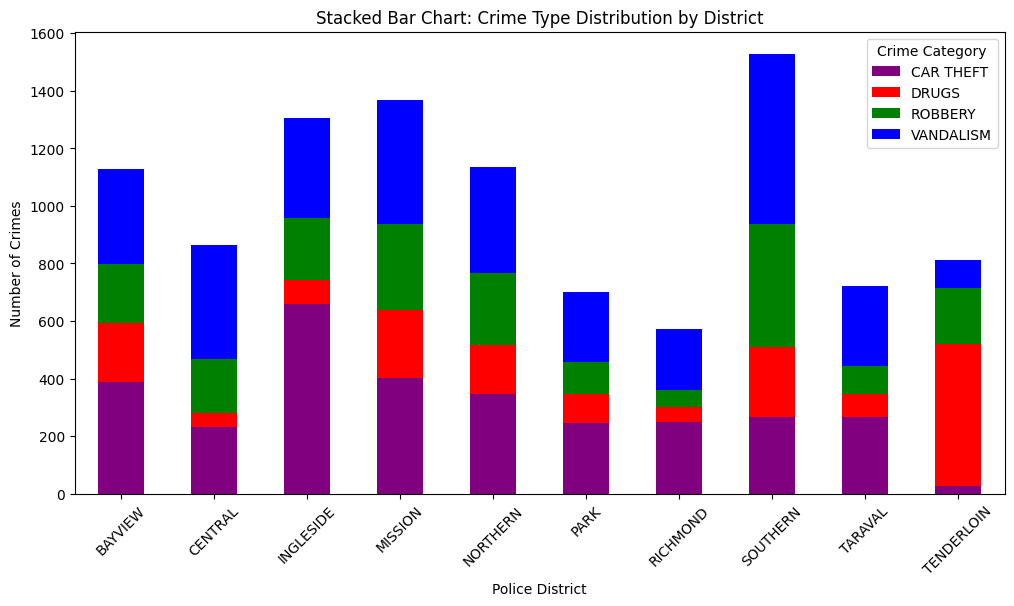

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot data for stacking
crime_pivot = crime_type_by_district.pivot(index="PdDistrict", columns="Category", values="crime_type_count").fillna(0)

# Define custom colors for each crime category
crime_colors = {
    "VANDALISM": "blue",
    "DRUGS": "red",
    "ROBBERY": "green",
    "CAR THEFT": "purple"
}

# Set figure size
plt.figure(figsize=(12, 6))

# Plot stacked bars with specified colors
crime_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), color=[crime_colors[col] for col in crime_pivot.columns])

# Customize labels and title
plt.xlabel("Police District")
plt.ylabel("Number of Crimes")
plt.title("Stacked Bar Chart: Crime Type Distribution by District")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Crime Category")

# Show plot
plt.show()


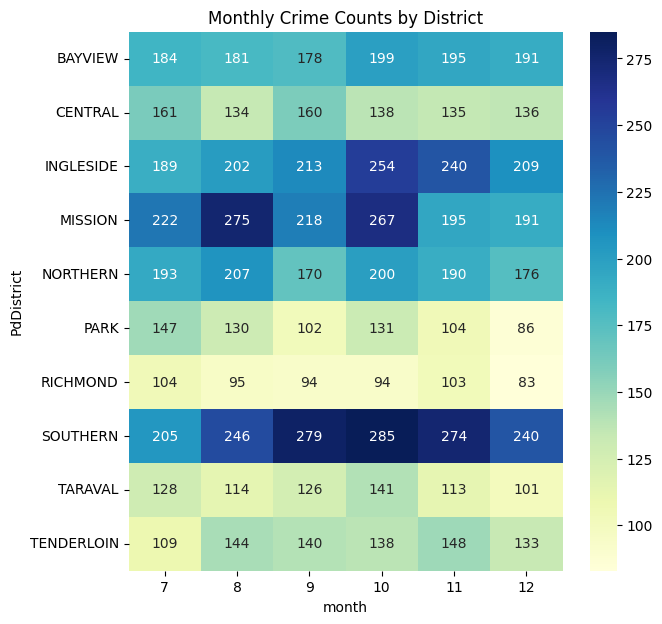

In [45]:

# 3. Temporal Analysis within Spatial Context
crime_with_sfpd['month'] = pd.to_datetime(crime_with_sfpd['DateTime']).dt.month
monthly_crime_with_sfpd = crime_with_sfpd.groupby(["PdDistrict", "month"]).size().reset_index(name="monthly_crime_count")

# 7. Temporal-Spatial Heatmap
plt.figure(figsize=(7, 7))
monthly_pivot = monthly_crime_with_sfpd.pivot(index="PdDistrict", columns="month", values="monthly_crime_count")
import seaborn as sns
sns.heatmap(monthly_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Monthly Crime Counts by District")
plt.show()

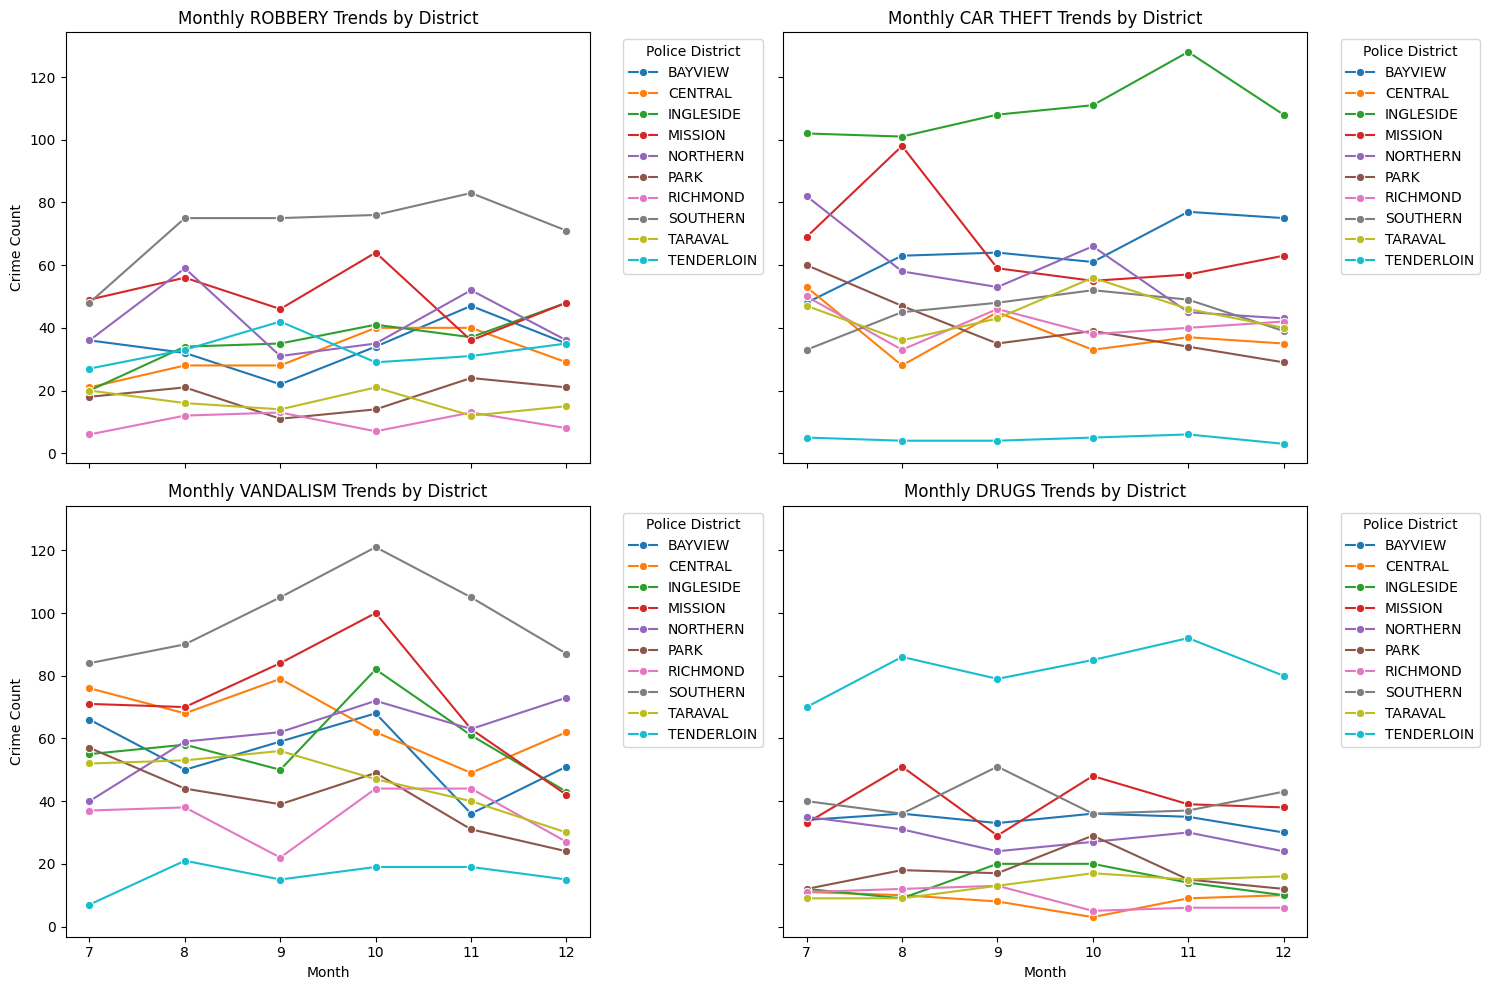

Patrol Adjustment Recommendations:

For ROBBERY:
  - Increase patrols in BAYVIEW during month 11 (Crime count: 47)
  - Increase patrols in CENTRAL during month 10 (Crime count: 40)
  - Increase patrols in INGLESIDE during month 12 (Crime count: 48)
  - Increase patrols in MISSION during month 10 (Crime count: 64)
  - Increase patrols in NORTHERN during month 8 (Crime count: 59)
  - Increase patrols in PARK during month 11 (Crime count: 24)
  - Increase patrols in RICHMOND during month 9 (Crime count: 13)
  - Increase patrols in SOUTHERN during month 11 (Crime count: 83)
  - Increase patrols in TARAVAL during month 10 (Crime count: 21)
  - Increase patrols in TENDERLOIN during month 9 (Crime count: 42)

For CAR THEFT:
  - Increase patrols in BAYVIEW during month 11 (Crime count: 77)
  - Increase patrols in CENTRAL during month 7 (Crime count: 53)
  - Increase patrols in INGLESIDE during month 11 (Crime count: 128)
  - Increase patrols in MISSION during month 8 (Crime count: 98)
  - Incr

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming monthly_crime_type is already created
monthly_crime_type = crime_with_sfpd.groupby(["PdDistrict", "month", "Category"]).size().reset_index(name="crime_type_count")

# Select the 4 crime types
crime_types = ["ROBBERY", "CAR THEFT", "VANDALISM", "DRUGS"]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Dictionary to store patrol adjustment recommendations
patrol_adjustments = {}

# Plot each crime type and identify peak months
for i, crime_type in enumerate(crime_types):
    monthly_data = monthly_crime_type[monthly_crime_type["Category"] == crime_type]
    sns.lineplot(data=monthly_data, x="month", y="crime_type_count", hue="PdDistrict", marker="o", ax=axes[i])
    axes[i].set_title(f"Monthly {crime_type} Trends by District")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Crime Count")
    axes[i].legend(title="Police District", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Identify peak month for each district
    peak_months = monthly_data.groupby("PdDistrict")["crime_type_count"].idxmax()
    peak_data = monthly_data.loc[peak_months, ["PdDistrict", "month", "crime_type_count"]]
    patrol_adjustments[crime_type] = peak_data

plt.tight_layout()
plt.show()

# Print patrol adjustment recommendations
print("Patrol Adjustment Recommendations:")
for crime_type, peak_data in patrol_adjustments.items():
    print(f"\nFor {crime_type}:")
    for _, row in peak_data.iterrows():
        district = row["PdDistrict"]
        month = row["month"]
        count = row["crime_type_count"]
        print(f"  - Increase patrols in {district} during month {month} (Crime count: {count})")

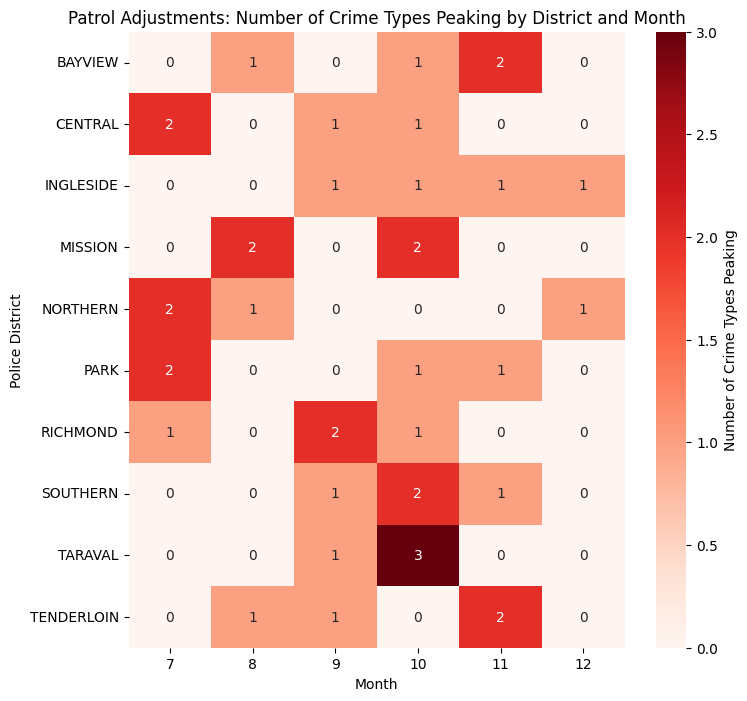

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming monthly_crime_type is already created
# monthly_crime_type = crime_with_sfpd.groupby(["PdDistrict", "month", "Category"]).size().reset_index(name="crime_type_count")

# Select the 4 crime types
crime_types = ["ROBBERY", "CAR THEFT", "VANDALISM", "DRUGS"]

# Identify peak months for each crime type and district
patrol_adjustments = {}
for crime_type in crime_types:
    monthly_data = monthly_crime_type[monthly_crime_type["Category"] == crime_type]
    peak_months = monthly_data.groupby("PdDistrict")["crime_type_count"].idxmax()
    peak_data = monthly_data.loc[peak_months, ["PdDistrict", "month", "crime_type_count"]]
    patrol_adjustments[crime_type] = peak_data

# Combine all peak data into a single DataFrame
peak_df = pd.concat([df.assign(Category=crime_type) for crime_type, df in patrol_adjustments.items()])

# Count how many crime types peak in each district-month combination
patrol_heatmap_data = peak_df.groupby(["PdDistrict", "month"]).size().reset_index(name="num_crime_types")

# Pivot the data for the heatmap
patrol_heatmap_pivot = patrol_heatmap_data.pivot(index="PdDistrict", columns="month", values="num_crime_types").fillna(0)

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(patrol_heatmap_pivot, cmap="Reds", annot=True, fmt=".0f", cbar_kws={'label': 'Number of Crime Types Peaking'})
plt.title("Patrol Adjustments: Number of Crime Types Peaking by District and Month")
plt.xlabel("Month")
plt.ylabel("Police District")
plt.show()

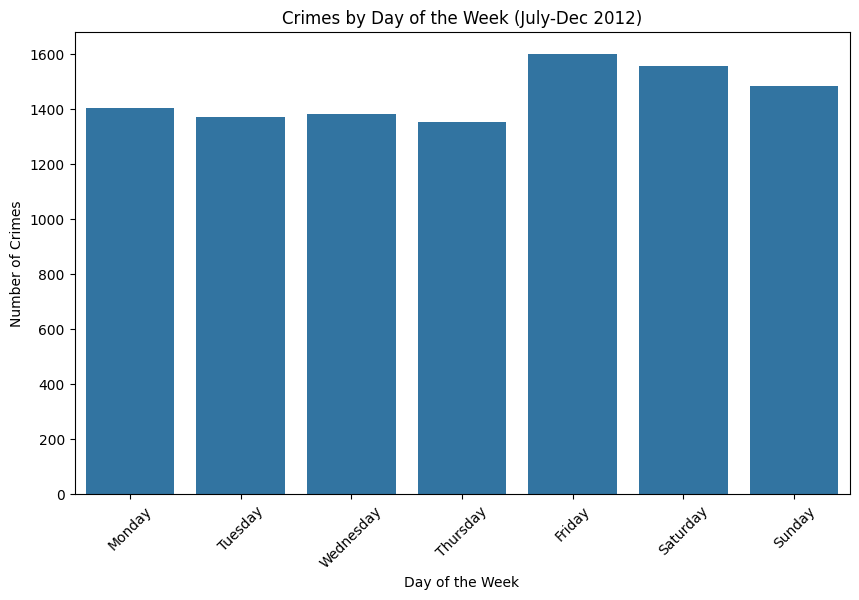

In [48]:
# Day-of-Week Analysis
dayofweek_crimes = crime_gdf.groupby('DayOfWeek').size().reset_index(name='crime_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayofweek_crimes['DayOfWeek'] = pd.Categorical(dayofweek_crimes['DayOfWeek'], categories=day_order, ordered=True)
dayofweek_crimes = dayofweek_crimes.sort_values('DayOfWeek')

# Plot crimes by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=dayofweek_crimes, x='DayOfWeek', y='crime_count')
plt.title('Crimes by Day of the Week (July-Dec 2012)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

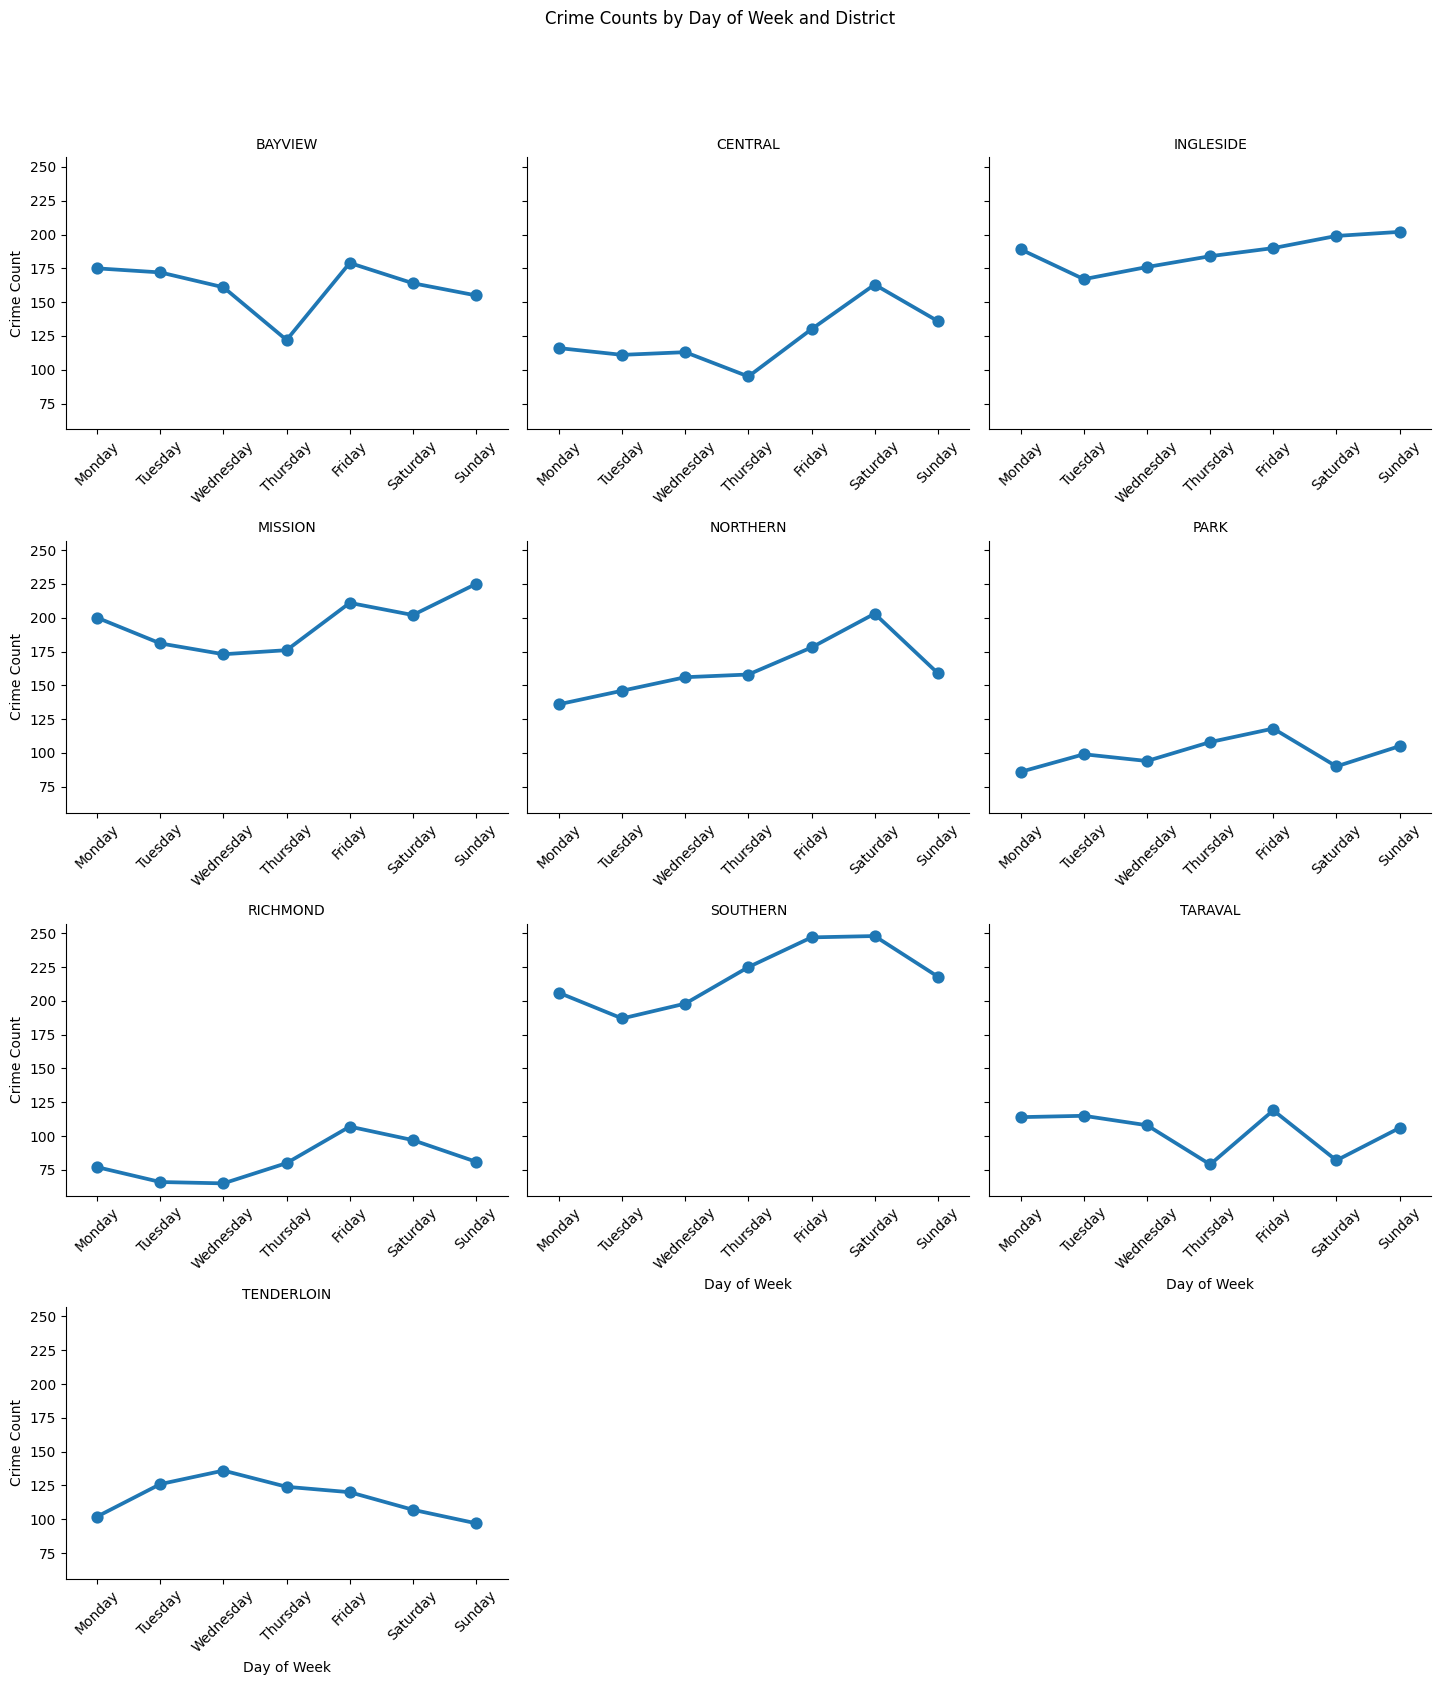

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by day of week and district
day_of_week_crime = crime_with_sfpd.groupby(["PdDistrict", "DayOfWeek"]).size().reset_index(name="day_of_week_crime_count")

# Order days of the week for better visualization
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_crime["DayOfWeek"] = pd.Categorical(day_of_week_crime["DayOfWeek"], categories=day_order, ordered=True)

# Visualize with faceted point plots
g = sns.catplot(
    data=day_of_week_crime, x="DayOfWeek", y="day_of_week_crime_count",
    col="PdDistrict", col_wrap=3, kind="point", height=4, aspect=1.2,
    sharex=False, sharey=True  # Important: Do not share x-axis
)

# Explicitly set x-axis categories for each subplot
for ax in g.axes.flat:
    ax.set_xticks(range(len(day_order)))
    ax.set_xticklabels(day_order, rotation=45)

g.set_axis_labels("Day of Week", "Crime Count")
g.set_titles("{col_name}")
g.fig.suptitle("Crime Counts by Day of Week and District", y=1.05)
plt.tight_layout()
plt.show()

THE END

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3c730f2-7678-4e5a-8ff5-b5a28ce04379' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>